---
# Unraveling the Spacetime Anomaly: Passenger Fate Prediction

**Author:** Martynas Loveikis

---
## Table of Contents

1. [Introduction](#introduction)
2. [Mission Objective](#mission-objective)
3. [Action Plan](#action-plan)
4. [Libraries](#libraries)
5. [Dataset](#dataset)
6. [Data Quirks](#data-quirks-a-titanic-puzzle)
7. [Exploratory Data Analysis](#exploratory-data-analysis)
8. [Data Cleaning](#data-cleaning)
9. [Statistical Inference](#statistical-inference)
10. [Data Preparation and Preprocessing](#data-preparation-and-preprocessing)
11. [Model Evaluation](#model-evaluation)
12. [Kaggle Submission](#kaggle-submission-the-final-showdown)
13. [Results](#results)

## introduction

___

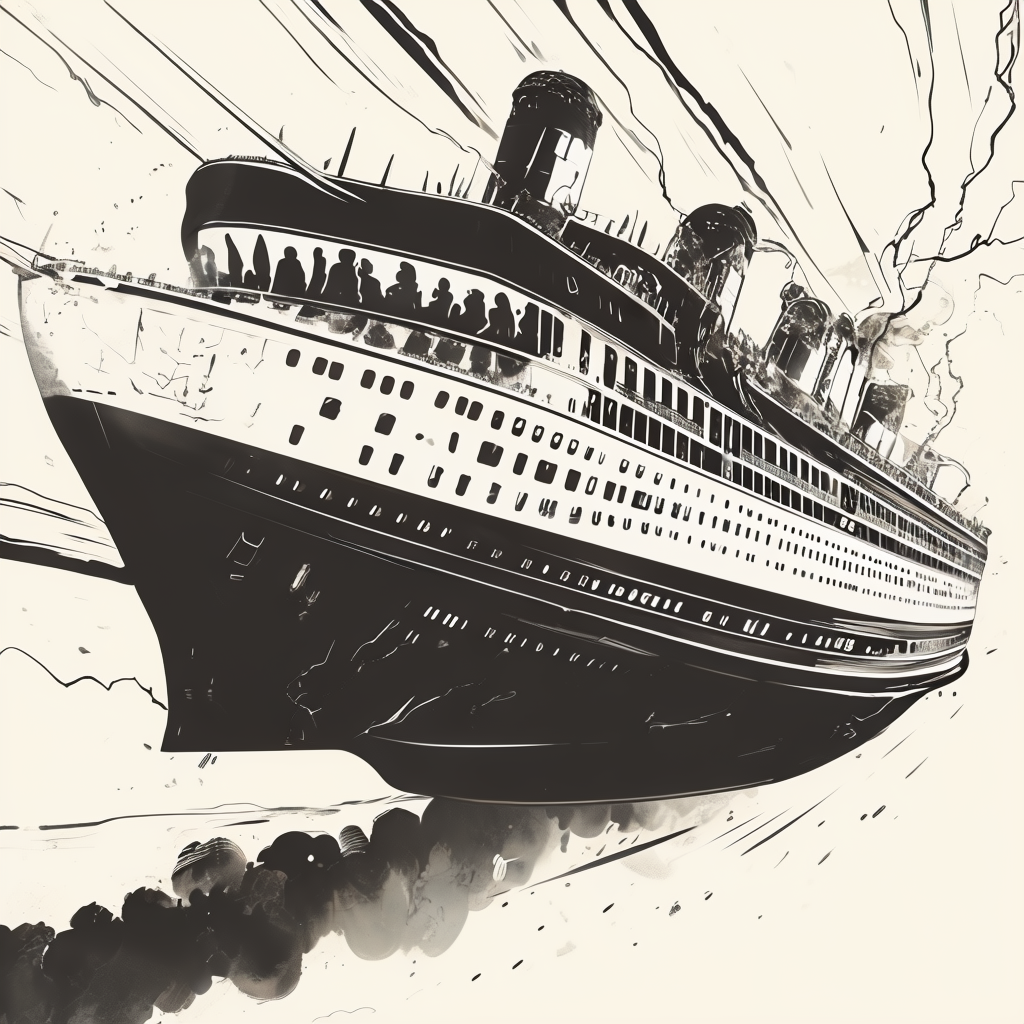

In [3]:
Image(filename="../images/titanic-spaceship.png")

This project: Analyzing the digital wreckage of the Spaceship Titanic.  **Basically, we're digital archaeologists sifting through the remains of a space catastrophe.** Fun.

## mission-objective

The goal?  **Predict who got zapped to another dimension.**  Simple enough. If only data were ever that cooperative.

## action-plan

Right, so the grand plan to predict dimensional teleportation is:

*   **Data Retrieval and Refinement:** Get the data. Clean it. *Yawn*.
*   **Exploratory Data Analysis:** Make some pretty charts. Look for patterns.  *Riveting*.
*   **Statistical Validation:**  Confirm our hunches with numbers. Because rigor is *key*.
*   **Predictive Modeling:** Machine learning magic. Predict the future.  *Hopefully*.
*   **Reporting and Recommendations:** Summarize. Conclude. Recommend.  The usual.

---
## libraries

In [2]:
import subprocess
import warnings
import zipfile
from typing import Dict, List

import helper_utils as help
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.core.display import HTML
from IPython.display import Image
from catboost import CatBoostClassifier
from kaggle.api.kaggle_api_extended import KaggleApi
from lightgbm import LGBMClassifier
from sklearn.base import ClassifierMixin
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import (
	ExtraTreesClassifier,
	GradientBoostingClassifier,
	RandomForestClassifier,
	RandomForestRegressor,
	StackingClassifier,
)
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import classification_report
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
	OneHotEncoder,
	StandardScaler,
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

warnings.filterwarnings("ignore")

**Import Fiesta: Data Science Edition**

- **Standard Libs**: `subprocess`, `warnings`, `zipfile`, `typing` â€“ Python's sidekicks.
- **Data Wrangling**: NumPy, Pandas â€“ the dynamic duo.
- **Viz**: Matplotlib â€“ because ugly plots are so last year.
- **ML Arsenal**: Scikit-learn, CatBoost, LightGBM, XGBoost â€“ overkill? Never heard of it.
- **Kaggle API**: For competitive procrastination.

*TL;DR*: Half of PyPI imported. Warnings ignored. Let the data games begin!


In [2]:
HTML(
	"""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
"""
)

plt.rcParams.update(
	{
		"font.family"          : "monospace",
		"axes.titlesize"       : 10,
		"axes.titlepad"        : 13,
		"axes.labelsize"       : 10,
		"xtick.labelsize"      : 10,
		"ytick.labelsize"      : 10,
		"legend.fontsize"      : 9,
		"legend.title_fontsize": 9,
	}
)

pd.set_option("display.float_format", "{:,.3f}".format)

Styling the output because default plots are *too mainstream*. We've got custom fonts with meticulously adjusted font sizes. Also, limiting floats to 3 decimal places because, *precision*.

In [3]:
api = KaggleApi()
api.authenticate()

api.competition_download_files("spaceship-titanic", path="../data")

with zipfile.ZipFile("../data/spaceship-titanic.zip", "r") as zip_ref:
    zip_ref.extractall("../data")

Downloading the "spaceship-titanic" dataset using the Kaggle API.  Because manual downloads are *so* last century. Then, unzipping it.  Standard stuff.

---
## dataset

Here's the passenger manifest.  *Thrilling*. 14 features for 8693 souls. Let's break down this *riveting* list:

*   **PassengerId:** `gggg_pp`.  Group ID and passenger number. Families *might* be grouped together. Maybe.
*   **HomePlanet:** Departure planet.  Presumably where they lived.
*   **CryoSleep:** Did they choose suspended animation? Yes or no.  (And confined to cabins. *Joy.*)
*   **Cabin:** `deck/num/side` (Port or Starboard).  Where they bunked.
*   **Destination:** Where they were headed.
*   **Age:** How old they were.
*   **VIP:** Paid for fancy extras?  Yes or no.
*   **RoomService, FoodCourt, ShoppingMall, Spa, VRDeck:** Luxury amenity bills. Because tracking individual spending is *essential*.
*   **Name:** First and last.  Groundbreaking.
*   **Transported:** The golden ticket: Did they get zapped to another dimension? (This is what we"re predicting, in case anyone cared.)

In [4]:
df = pd.read_csv("../data/train.csv")
help.check_df(df, transpose=False)

############## Shape ##############


(8693, 14)


############## Types ##############


Data Type
PassengerId     object
HomePlanet      object
CryoSleep       object
Cabin           object
Destination     object
Age            float64
VIP             object
RoomService    float64
FoodCourt      float64
ShoppingMall   float64
Spa            float64
VRDeck         float64
Name            object
Transported       bool


############## Quantiles ##############


Age  RoomService  FoodCourt  ShoppingMall        Spa     VRDeck
count 8,514.000    8,512.000  8,510.000     8,485.000  8,510.000  8,505.000
mean     28.828      224.688    458.077       173.729    311.139    304.855
std      14.489      666.718  1,611.489       604.696  1,136.706  1,145.717
min       0.000        0.000      0.000         0.000      0.000      0.000
0%        0.000        0.000      0.000         0.000      0.000      0.000
5%        4.000        0.000      0.000         0.000      0.000      0.000
50%      27.000        0.000      0.000         0.000      0.000      0.000
95%      56.000    1,274.250  2,748.500       927.800  1,607.100  1,534.200
99%      65.000    3,096.230  8,033.310     2,333.440  5,390.100  5,646.680
100%     79.000   14,327.000 29,813.000    23,492.000 22,408.000 24,133.000
max      79.000   14,327.000 29,813.000    23,492.000 22,408.000 24,133.000


############## Head ##############


PassengerId HomePlanet CryoSleep  Cabin  Destination    Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e 39.000  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e 24.000  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck             Name  \
0        0.000      0.000         0.000   0.000   0.000  Maham Ofracculy   
1      109.000      9.000        25.000 549.000  44.000     Juanna Vines   

   Transported  
0        False  
1         True


############## Tail ##############


PassengerId HomePlanet CryoSleep    Cabin  Destination    Age    VIP  \
8691     9280_01     Europa     False  E/608/S  55 Cancri e 32.000  False   
8692     9280_02     Europa     False  E/608/S  TRAPPIST-1e 44.000  False   

      RoomService  FoodCourt  ShoppingMall     Spa    VRDeck  \
8691        0.000  1,049.000         0.000 353.000 3,235.000   
8692      126.000  4,688.000         0.000   0.000    12.000   

                  Name  Transported  
8691  Celeon Hontichre        False  
8692  Propsh Hontichre         True


############## Unique Value Check ##############


Column  Unique Value Count
2      CryoSleep                   2
6            VIP                   2
13   Transported                   2
1     HomePlanet                   3
4    Destination                   3
5            Age                  80
9   ShoppingMall                1115
7    RoomService                1273
11        VRDeck                1306
10           Spa                1327
8      FoodCourt                1507
3          Cabin                6560
12          Name                8473
0    PassengerId                8693


############## NA ##############


PassengerId       0
Transported       0
Age             179
RoomService     181
Destination     182
FoodCourt       183
Spa             183
VRDeck          188
Cabin           199
Name            200
HomePlanet      201
VIP             203
ShoppingMall    208
CryoSleep       217
dtype: int64


############## Duplicate Rows ##############
No duplicate rows found in the DataFrame.


## data-quirks-a-titanic-puzzle

"Quirks." Right. Let's translate:

*   **Missing Values:** Surprise! Data's incomplete. `PassengerId` and `Transported` are the *only* complete ones.
*   **No Duplicates:** A statistical anomaly. No identical rows. How... *unique*.
*   **High Cardinality:** `Cabin`, `Name`, `PassengerId` are *overflowing* with unique values. Fun times ahead.
*   **Expenditure Consolidation:** Shoving all spend into one column. Because details are overrated. *Fine*, we'll combine the `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, and `VRDeck` features into a single "TotalSpent" column. This *might* help identify passengers who spent nothing, potentially revealing... something?  Who knows. It's worth a shot, I guess.
*   **Age Insights:** Median age is 27. Range is 0â€“79. Groundbreaking stuff.

Smooth sailing ahead? With these quirks?  Doubtful.

---
# exploratory-data-analysis

Translation: **Digging through the data for clues.**  Let's see what secrets this dataset is hiding. (Hopefully, something more interesting than the average age.)

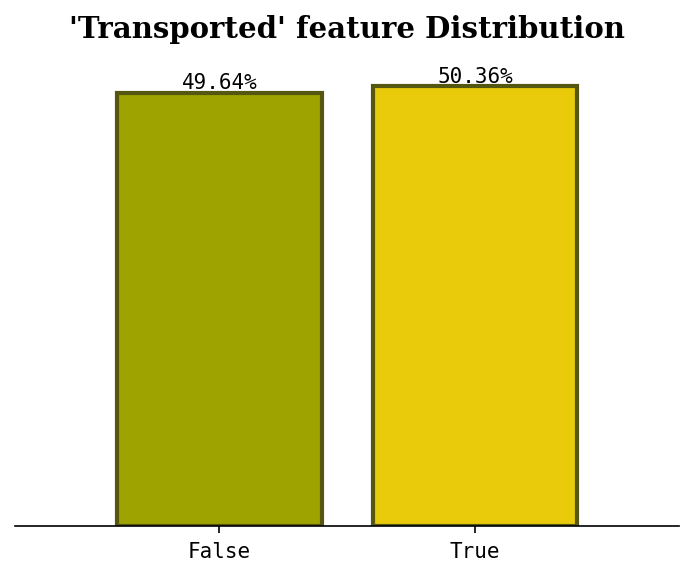

In [5]:
help.barcharts_by_group(df, target_variables=["Transported"])

PThe `Transported` bar chart: A *thrilling* near 50/50 split.  **Half zapped, half not.**  Balanced.  How...predictable. (50.36% zapped, to be precise.)

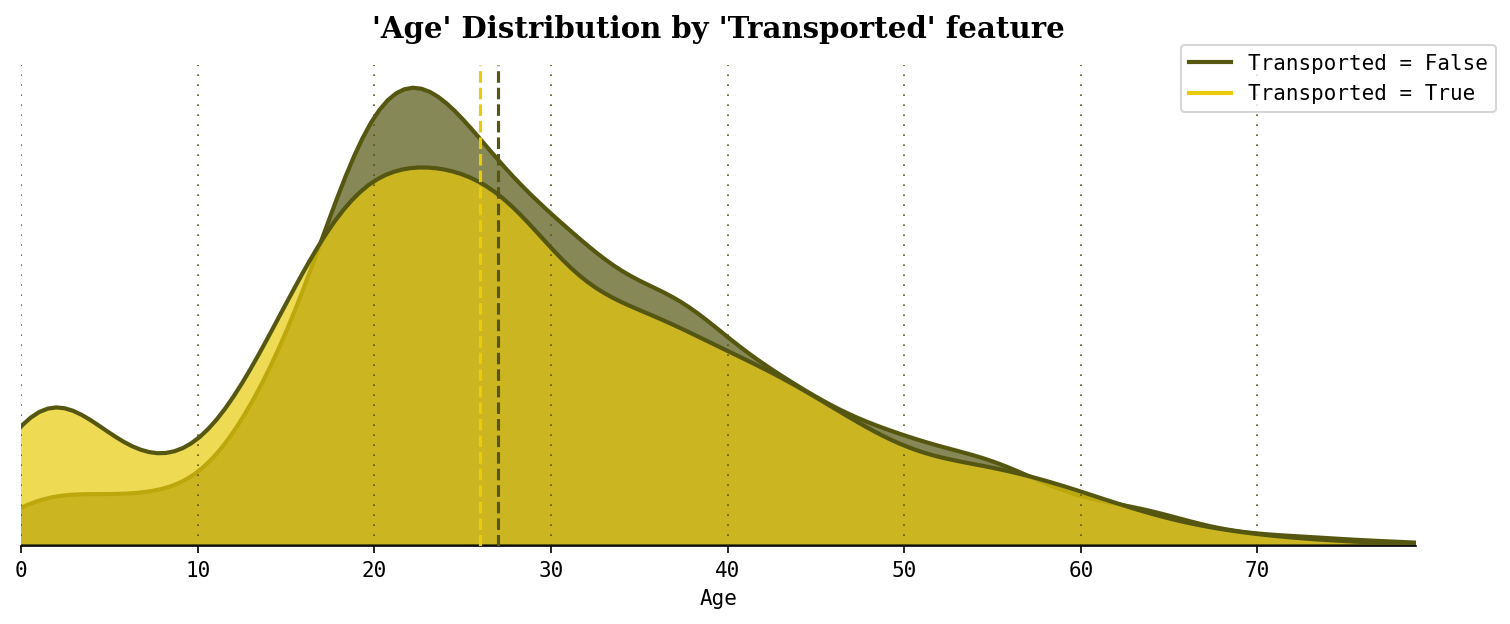

In [6]:
help.graph_by_group(df, target_variables=["Age"],
                    group_variable="Transported",
                    legend_x=0.95, legend_y=0.90)

Age distribution: Transported had more young'uns (0â€“16) and fewer in the 16â€“40 range.  Older folks? No real difference. **Conclusion:** Babies are better at dimension-hopping. We'll bin ages accordingly, because these differences are *obviously* key.

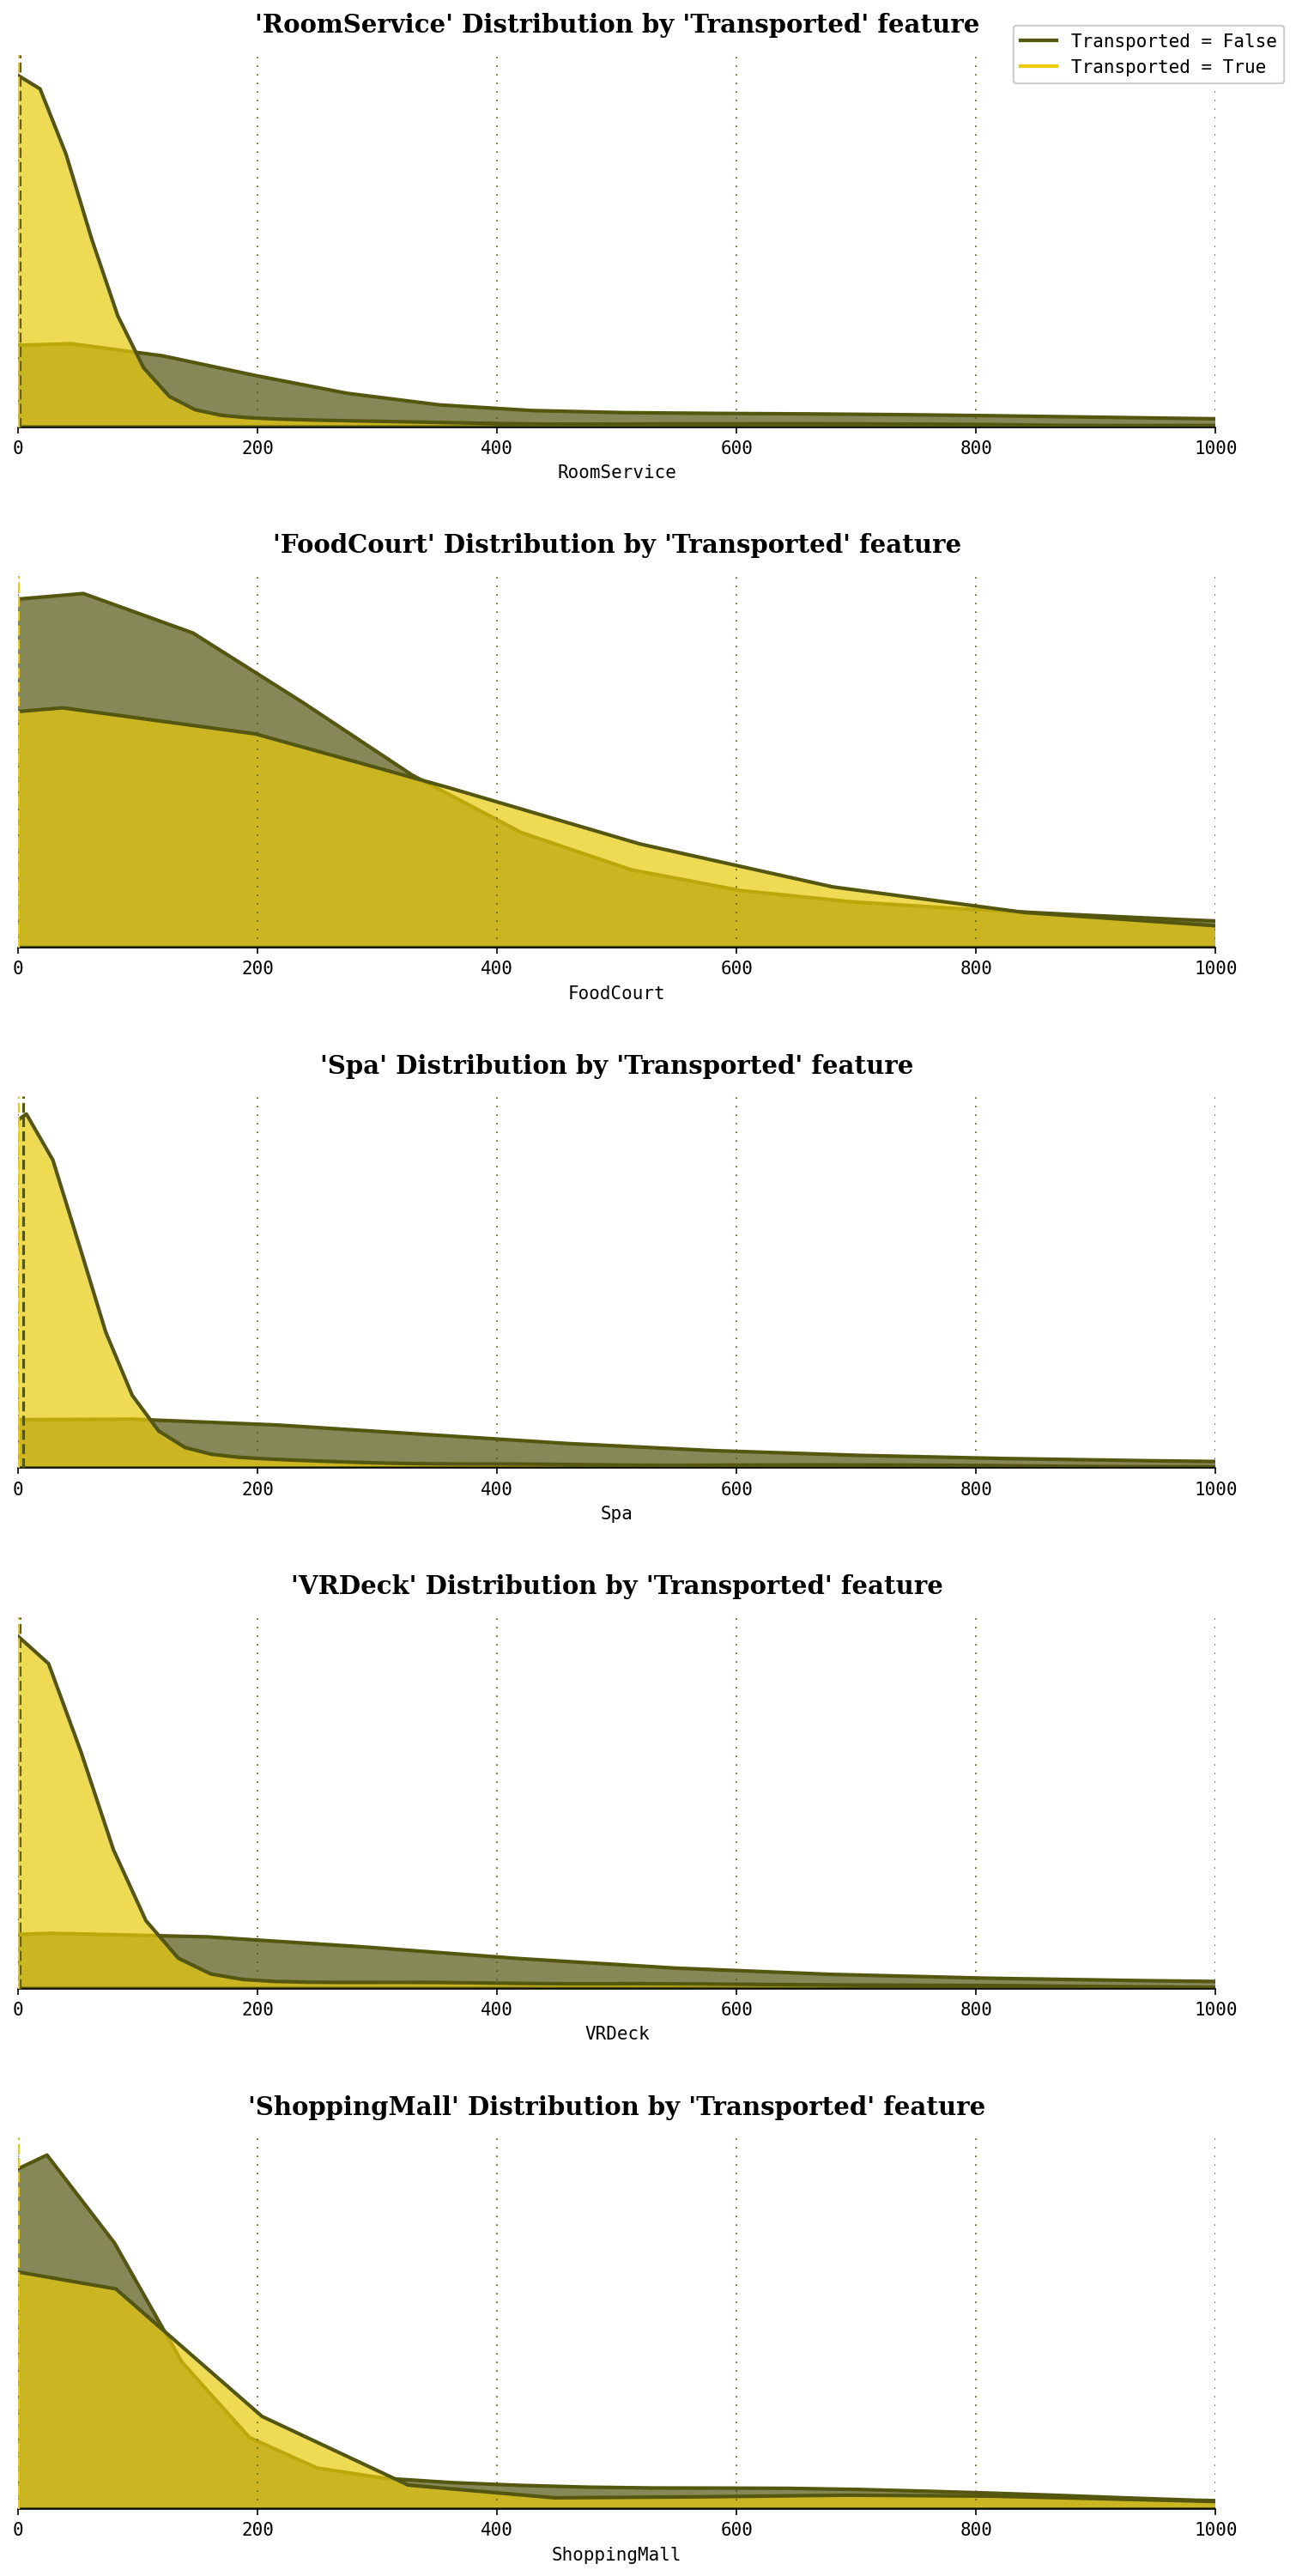

In [7]:
help.graph_by_group(df, target_variables=["RoomService",
                                          "FoodCourt",
                                          "Spa",
                                          "VRDeck",
                                          "ShoppingMall"], group_variable="Transported",
                    x_max_clip=1000, legend_x=0.95, legend_y=0.89)

To avoid graph overload, we're capping the spending at $1000.  `FoodCourt` and `ShoppingMall`?  No big difference under a grand. But `RoomService`, `Spa`, and `VRDeck`?  **Spend over a hundred there, and your chances of staying put apparently go up.**  Luxury keeps you grounded, literally. 
To boost model accuracy, We'll conjure up some new features: a sum for luxury services, a sum for basic services, and a boolean flag for those who spent absolutely nothing. **Because fiscal responsibility in space might just be the key to interdimensional stability.**

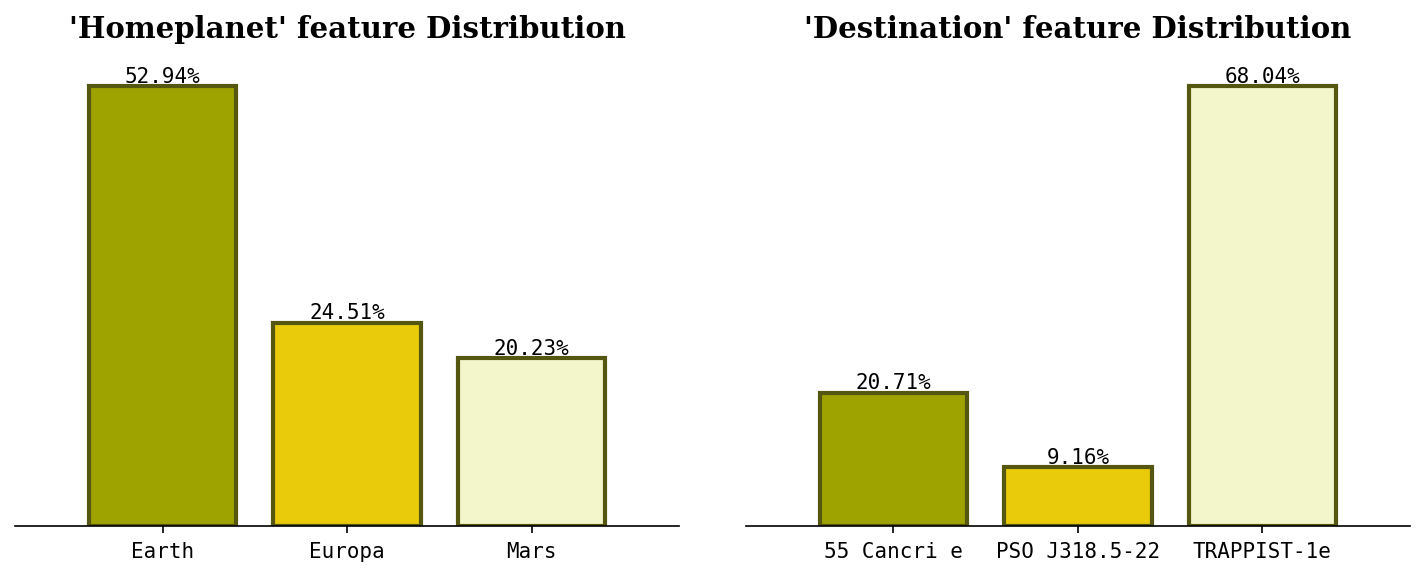

In [8]:
help.barcharts_by_group(df, target_variables=["HomePlanet", "Destination"])

Over half the passengers were Earthlings (52.94%), and most were TRAPPIST-1e bound (68.04%). **Guess that planet's got something special.** Or maybe Earth just really wasn't cutting it anymore.

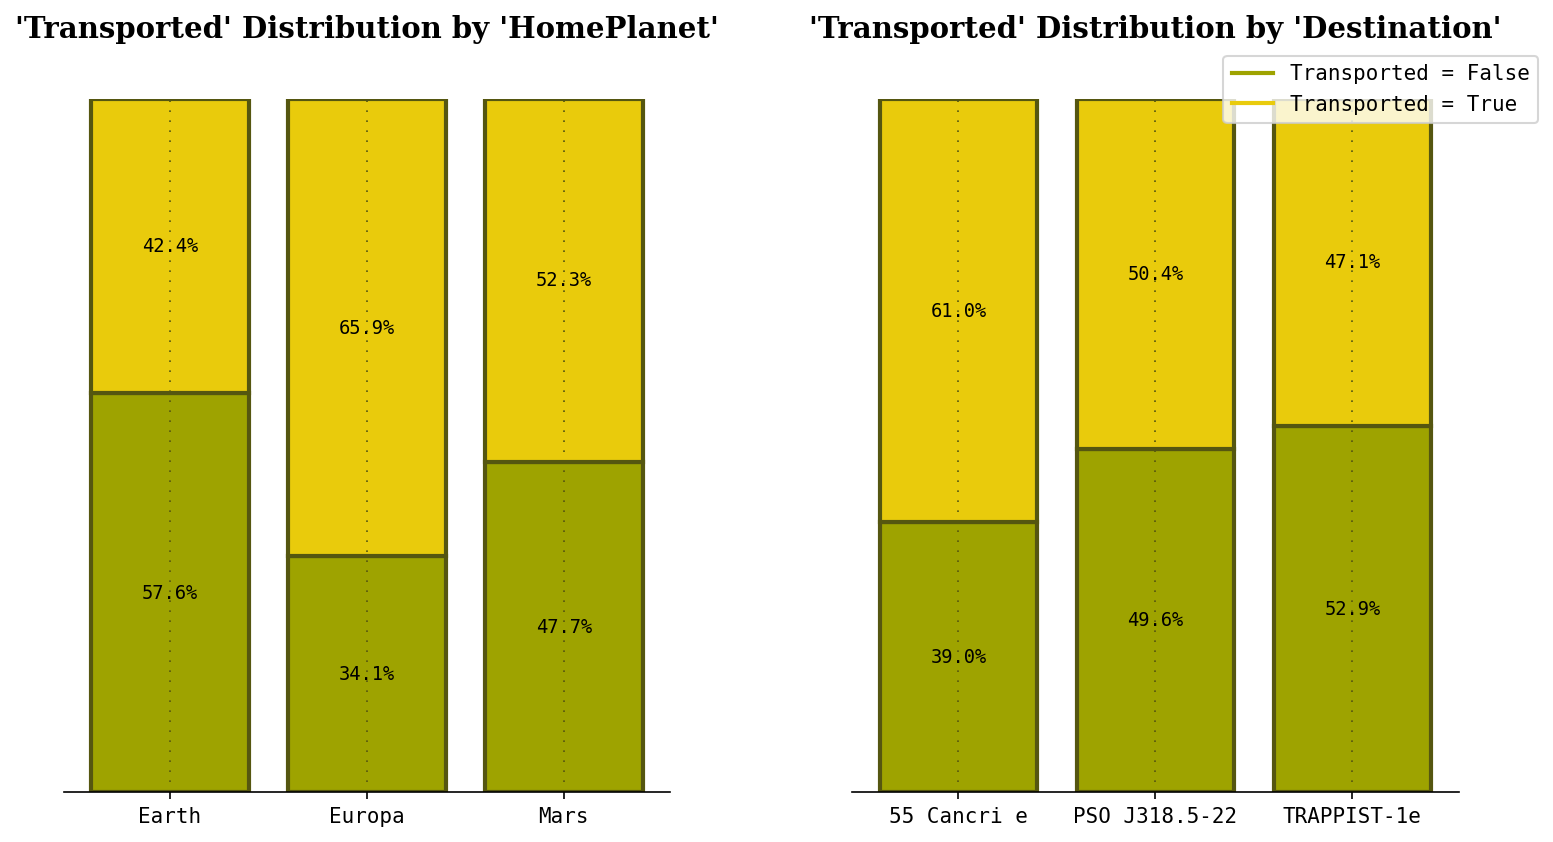

In [9]:
help.stacked_barcharts_by_group(df, group_variable="Transported",
                                target_variables=["HomePlanet", "Destination"],
                                transpose=True,
                                legend_x=0.95,
                                legend_y=0.94)

Grouped by `Transported`, it seems Europa is the VIP lounge for dimensional travel (two-thirds got zapped), followed by Mars (around 50%) and then Earth with a measly 42.4%. As for destinations, 55 Cancri e has the highest teleportation rate (61%), while the popular TRAPPIST-1e lags at 47.1%. **Moral of the story: Where you're from and where you're going *might* influence your chances of an unplanned dimension hop.**

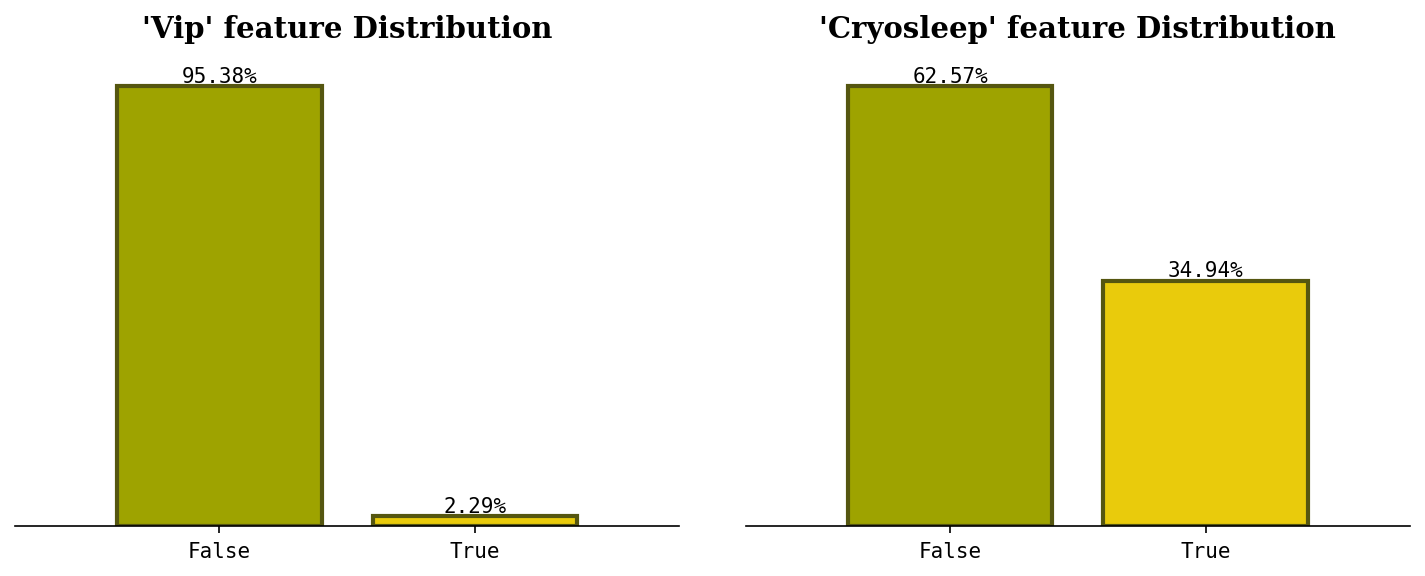

In [10]:
help.barcharts_by_group(df, target_variables=["VIP", "CryoSleep"])

Almost all VIPs (95.38%) were *not* transported. Money talks, even in space. And over two-thirds of CryoSleep were also not transported. **At first glance it looks like being frozen and rich helps you stay put.**

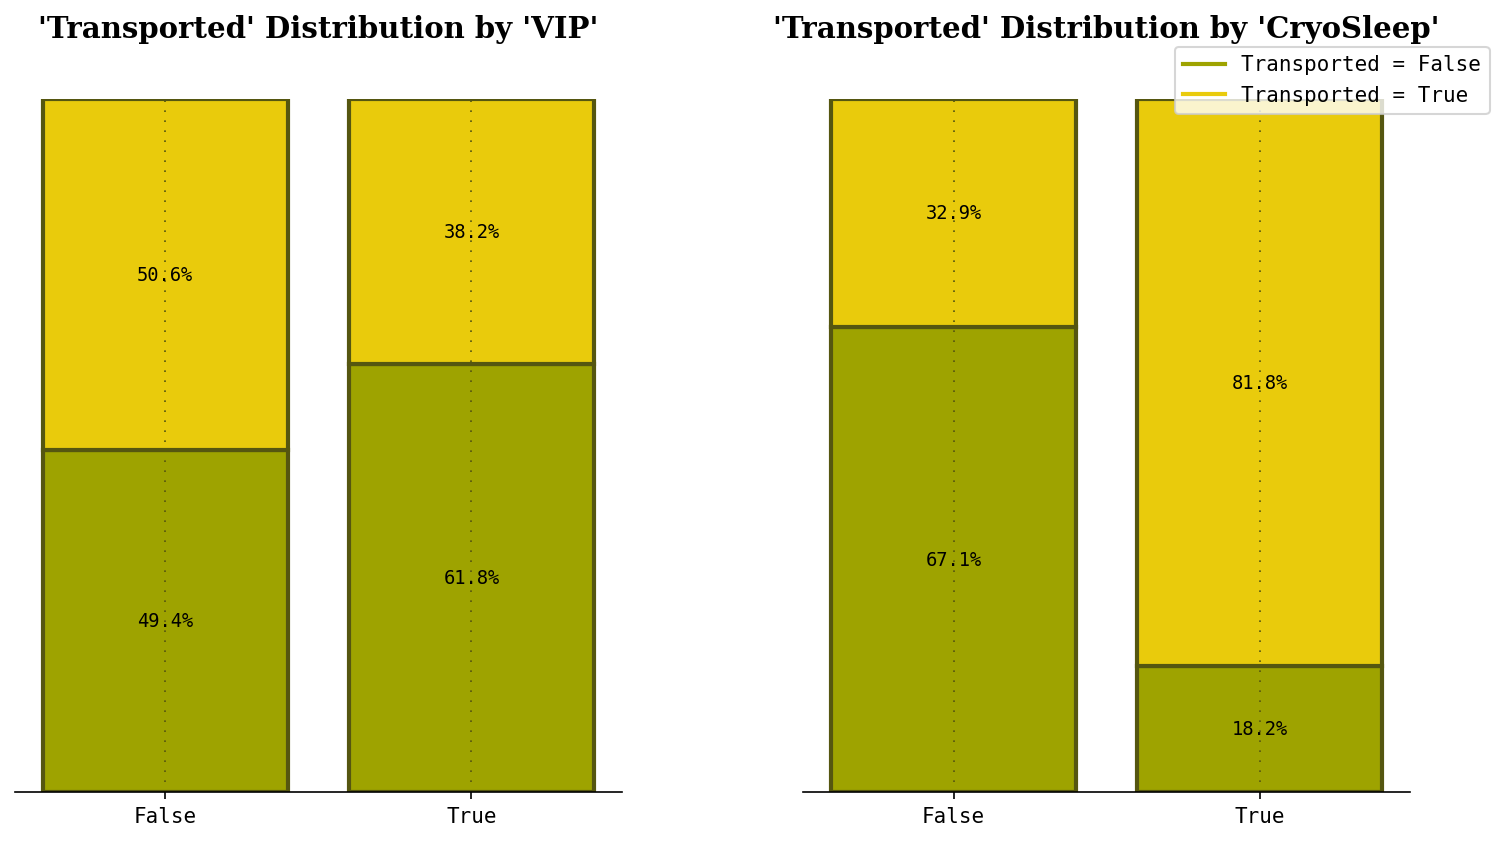

In [11]:
help.stacked_barcharts_by_group(df, target_variables=["VIP", "CryoSleep"],
                                group_variable="Transported",
                                transpose=True,
                                legend_x=0.95,
                                legend_y=0.95)

Comparing by `Transported`, `VIP` status offers a small advantage, with only 38.2% zapped.  But `CryoSleep` is the real shocker: 81.8% of those frozen folks got teleported. **Cryogenics, it seems, increases your chances of an unplanned dimensional trip.**

# data-cleaning

Alright, time for the *thrilling* data cleaning.  Filling in the blanks and conjuring up new features.  **Because data, in its natural state, is never good enough.**

In [12]:
transformers = [
	help.SplitColumn(
		column_name="PassengerId",
		delimiter="_",
		num_splits=2,
		new_column_names=["Group", "GroupNum"]
	),
	help.SplitColumn(
		column_name="Cabin",
		delimiter="/",
		num_splits=3,
		new_column_names=["CabinDeck", "CabinNumber", "Side"],
		remove_original=True
	),
	help.SplitColumn(
		column_name="Name",
		delimiter=" ",
		num_splits=2,
		new_column_names=["FirstName", "LastName"],
		remove_original=True
	)
]

df_EDA = df.copy()
for transformer in transformers:
	df_EDA = transformer.fit_transform(df_EDA)

In [13]:
group_sizer = help.GroupSize()
money_counter = help.CalculateSpend()

df_EDA = group_sizer.fit_transform(df_EDA)
df_EDA = money_counter.fit_transform(df_EDA)

## New Visuals
Our new feature, now in visual form. **Hopefully, these charts reveal something more than just our ability to create new columns.**

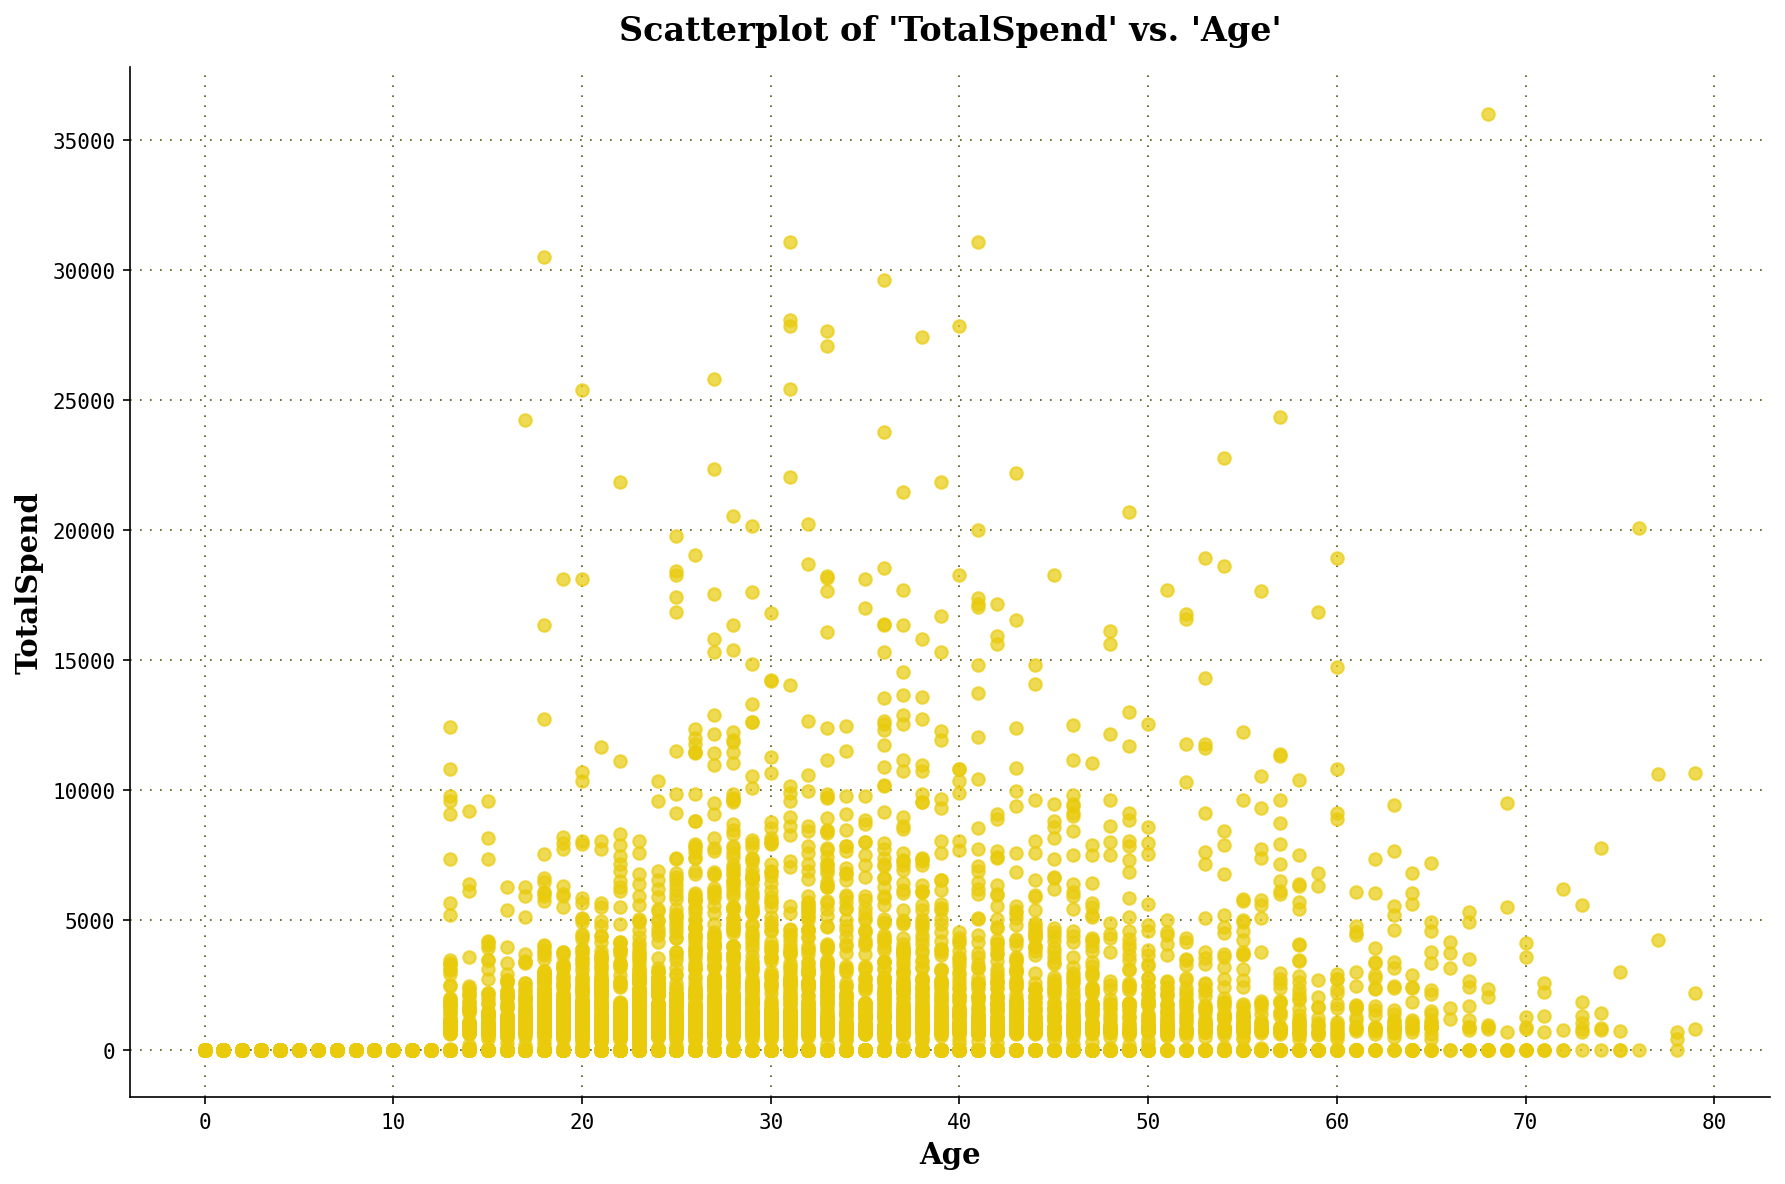

In [14]:
help.scatterplot(df_EDA, x_variable="Age", y_variable="TotalSpend")

As expected, kids 12 and under weren't spending a dime.  **Because, you know, they're *kids*.**  Good.

In [15]:
bin_age = help.BinColumn(
	bins=[-1, 1, 3, 12, 18, 25, 59, 80],
	labels=["baby", "toddler", "child", "teen",
	        "adult", "middle_age", "senior"],
	column_name="Age",
	strategy="manual",
	new_column_name="AgeGroup"
)
df_EDA = bin_age.fit_transform(df_EDA)

In [16]:
df_EDA["GroupNum"].nunique()

8

In [17]:
string_list = ["FirstName", "LastName"]
categorical_list = ["HomePlanet", "Destination", "CabinDeck", "Side", "GroupNum", "GroupSize"]
boolean_list = ["CryoSleep", "VIP", "Transported",
                "TravellingSolo", "ZeroSpend"]

df_EDA[string_list] = df_EDA[string_list].astype(str)
df_EDA[categorical_list] = df_EDA[categorical_list].astype("category")
df_EDA[boolean_list] = df_EDA[boolean_list].astype(bool)

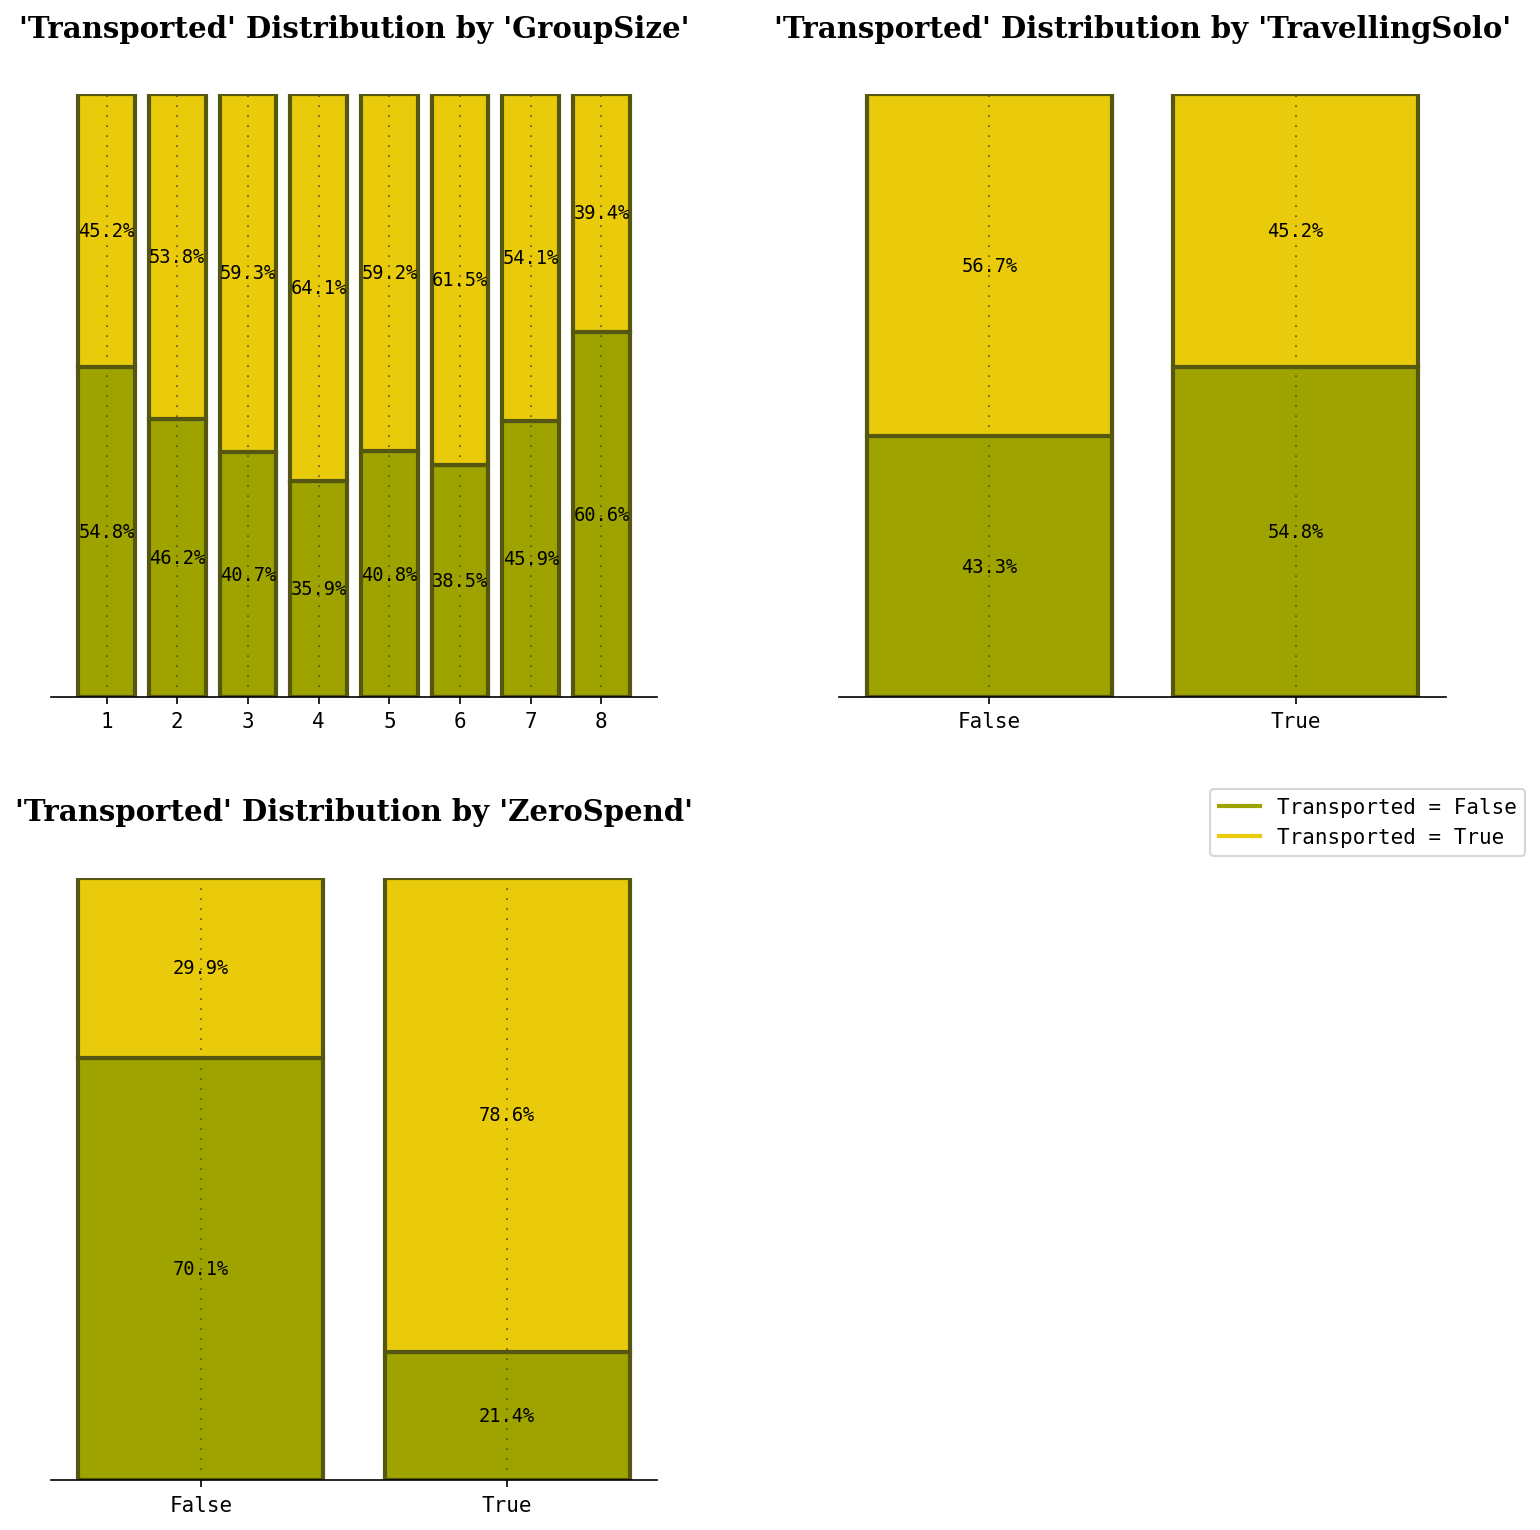

In [18]:
help.stacked_barcharts_by_group(df_EDA,
                                target_variables=["GroupSize",
                                                  "TravellingSolo",
                                                  "ZeroSpend"],
                                group_variable="Transported",
                                transpose=True,
                                legend_x=0.95,
                                legend_y=0.5)

Two takeaways: One, spending *anything* gives you a 70.1% chance of staying put; otherwise, it's a 78.6% chance of getting zapped. **Spend to remain, or get lost in space.** Two, those in groups of eight (60.6%) and solo travelers (54.8%) were the *least* likely to be teleported. **Apparently, there's a sweet spot for group size when it comes to avoiding interdimensional abduction.**

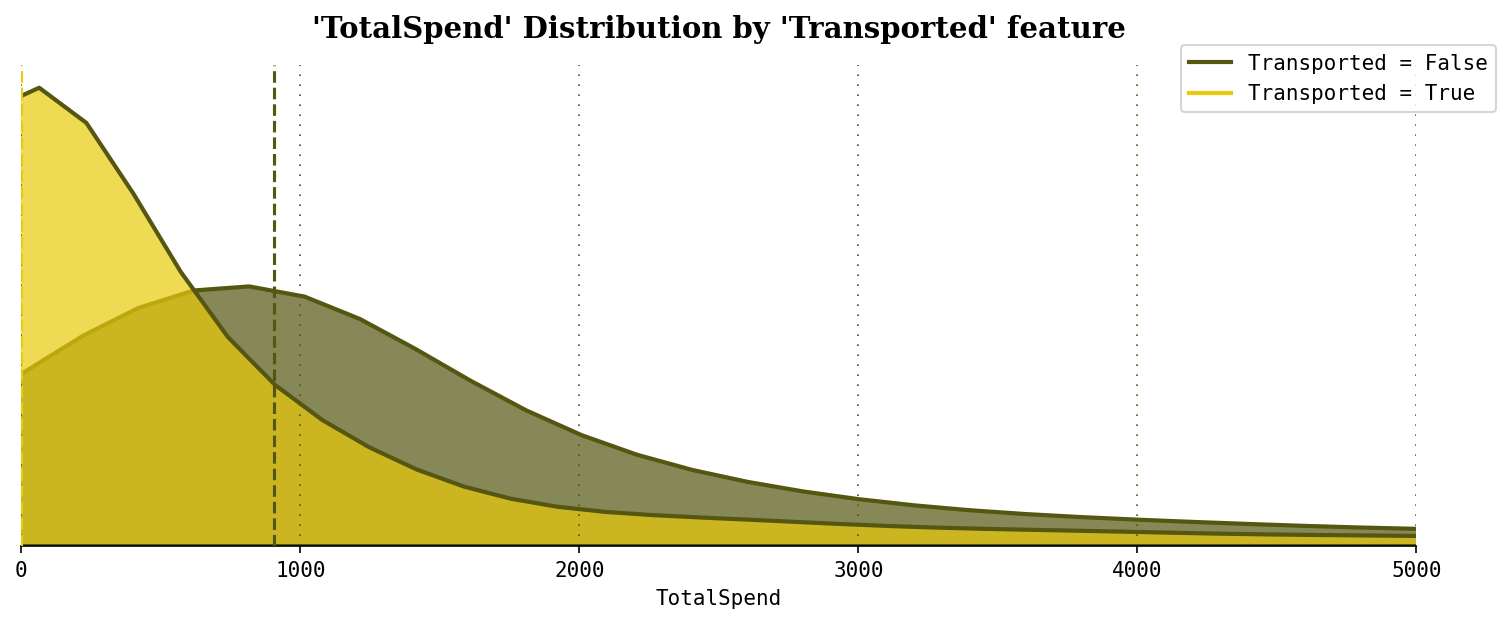

In [19]:
help.graph_by_group(df_EDA, target_variables=["TotalSpend"],
                    group_variable="Transported",
                    legend_x=0.95, legend_y=0.90, x_max_clip=5000)

This graph confirms it: a median spend of around 900 keeps you grounded, while a median of 0 has the highest teleportation rate. **Spend to stay, or be thrifty and get zapped.**  The universe has a strange sense of economics.

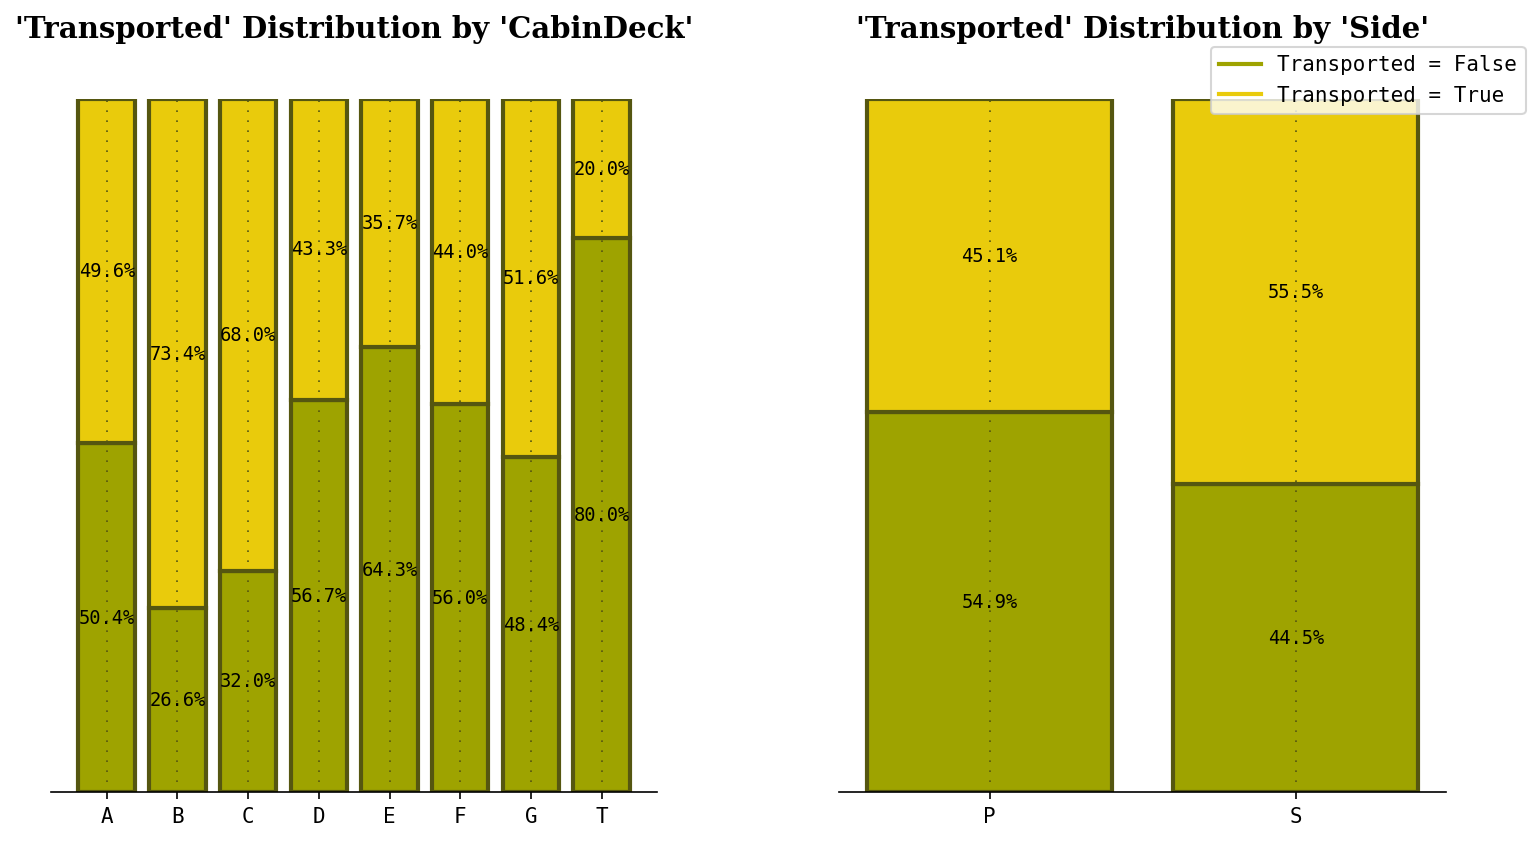

In [20]:
help.stacked_barcharts_by_group(df_EDA,
                                target_variables=["CabinDeck", "Side"],
                                group_variable="Transported",
                                transpose=True,
                                legend_x=0.95,
                                legend_y=0.95)

Cabin Deck B had a 73.4% teleportation rate, and Deck C wasn't far behind at 68%. **Looks like your choice of cabin deck *seriously* impacted your chances of an unplanned dimension hop.** Real estate is everything, even in space. And if you were on the Starboard side, you had a 55.5% chance of being zapped. **Port or Starboard suddenly becomes a life-altering decision.**

# NaN Value Imputation

Time to fill in those pesky missing values. **Because incomplete data is the bane of every analyst's existence.** Let's see what we can salvage.

First, let's see how many NaNs are lurking in each row. **Because knowing the *extent* of the missing data is half the battle.**

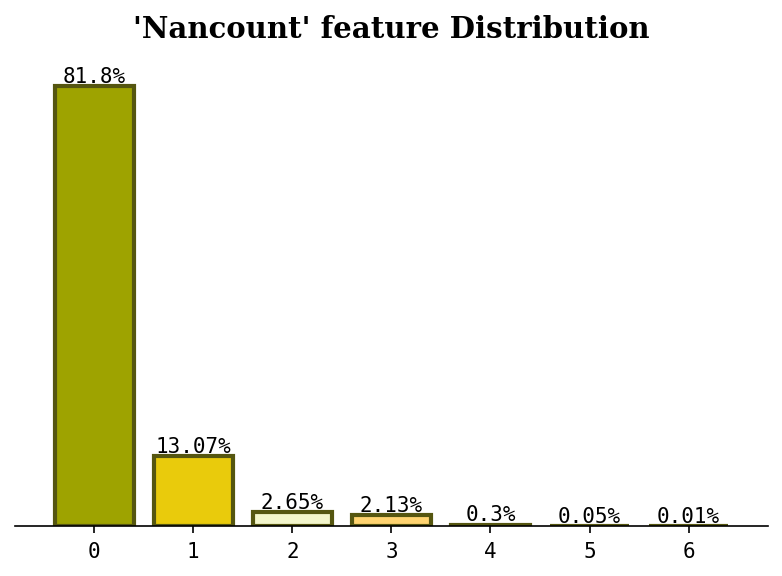

In [21]:
df_EDA["NaNCount"] = df_EDA.isna().sum(axis=1)

help.barcharts_by_group(df_EDA, target_variables=["NaNCount"])

About 18.2% of rows have NaNs, with most (13.7%) missing just one value.  **Not ideal, but at least it's not a complete data desert.**

One way to fill these NaNs is to play detective and look for clues in other columns. **Time to put on our data sleuthing hats.**

To begin with:
We know those aged 0â€“12 didn't spend anything.  Let's check if any of them have missing values in the spending columns. **Because space allowances for kids are probably not a thing.**

In [22]:
df_EDA.loc[(df_EDA["Age"] < 13), ["RoomService",
                                  "FoodCourt",
                                  "Spa",
                                  "VRDeck",
                                  "ShoppingMall"]].isnull().sum()

RoomService     20
FoodCourt       12
Spa             14
VRDeck          24
ShoppingMall    20
dtype: int64

As established, child passengers didn't spend a dime. We'll *explicitly* set any remaining missing spending values for them to 0. **Ensuring no accidental charges for juice boxes and crayons.**

In [23]:
df_EDA.loc[(df_EDA["CryoSleep"] == True), ["RoomService",
                                           "FoodCourt",
                                           "Spa",
                                           "VRDeck",
                                           "ShoppingMall"]].isnull().sum()

RoomService      70
FoodCourt        73
Spa              70
VRDeck           69
ShoppingMall    104
dtype: int64

CryoSleep passengers also have zero spend. **Frozen folks don't order room service, use the spa, or hit the VR deck.** Setting their missing spending values to 0, too.

Now we'll check if `HomePlanet` is consistent within each `Group`. **Because group members *probably* originated from the same planet.**  Unless it's a *very* mixed group.

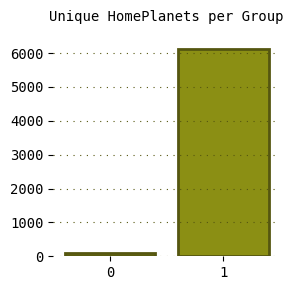

In [24]:
help.unique_group_counts(df_EDA,
                         groupby_col="Group",
                         count_cols=["HomePlanet"])

There's a tiny, practically invisible sliver representing groups with zero unique `HomePlanet` values (all NaNs, most likely). But the vast majority have only one `HomePlanet` per group. We'll impute missing `HomePlanet` values using the group's mode (most frequent planet). **Family space trips, same planet.** Solo travelers, however, get tagged with "Unknown" `HomePlanet`, as they lack group context.

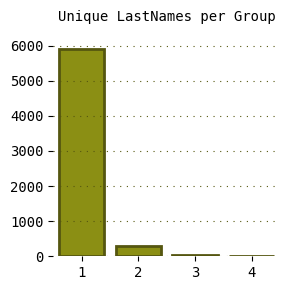

In [25]:
help.unique_group_counts(df_EDA,
                         groupby_col="Group",
                         count_cols=["LastName"])

Since most groups have only one unique `LastName`, we're betting on family connections. Missing `LastName` values within a group will be replaced with the group's most frequent last name. **Because "Smiths" travel together, even in space.** However, solo travelers (`SoloTravel` groups) get "Unknown" for both `LastName` and `FirstName`.  No family clues there.

Next, we'll examine the distribution of groups across different `Deck`, `Cabin`, and `Side` values. **Because knowing where people bunked might reveal... something. Or nothing. We'll see.**

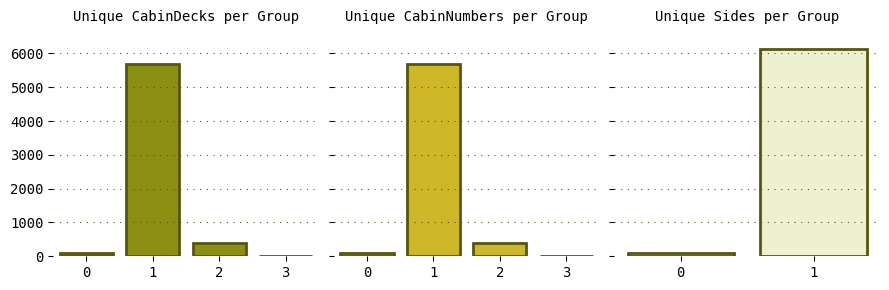

In [26]:
help.unique_group_counts(df_EDA,
                         groupby_col="Group",
                         count_cols=["CabinDeck", "CabinNumber", "Side"])

`CabinDeck` and `CabinNum` show up to three unique values per group (plus NaNs, represented by "0"). `Side` only has up to two (again NaNs as "0"). **We'll impute missing `Side` values with the most frequent side within each group.** Because, even in space, people probably don't teleport between ship sides *within* their group.

Let's investigate the `HomePlanet` and `CabinDeck` connection to see if certain decks were planet-specific. **Because segregation in space is a thing, apparently.**

In [27]:
df_EDA.pivot_table(
	index="CabinDeck",
	columns="HomePlanet",
	aggfunc="size",
	fill_value=0
)

HomePlanet  Earth  Europa  Mars
CabinDeck                      
A               0     252     0
B               0     766     0
C               0     734     0
D               0     186   282
E             395     128   330
F            1614       0  1110
G            2498       0     0
T               0       4     0

We've already established the planet-cabin connection: Europa = A, B, C, T; Earth = G; others = mixed. **We'll now *use* this to impute missing `CabinDeck` values, assigning Europa to those decks and Earth to G.** Because consistent patterns are our friends (or at least, useful).

Next, let's investigate the `VIP` feature. First, we'll find the minimum age at which someone is flagged as `VIP`. **Because child VIPs in space would be... interesting.**

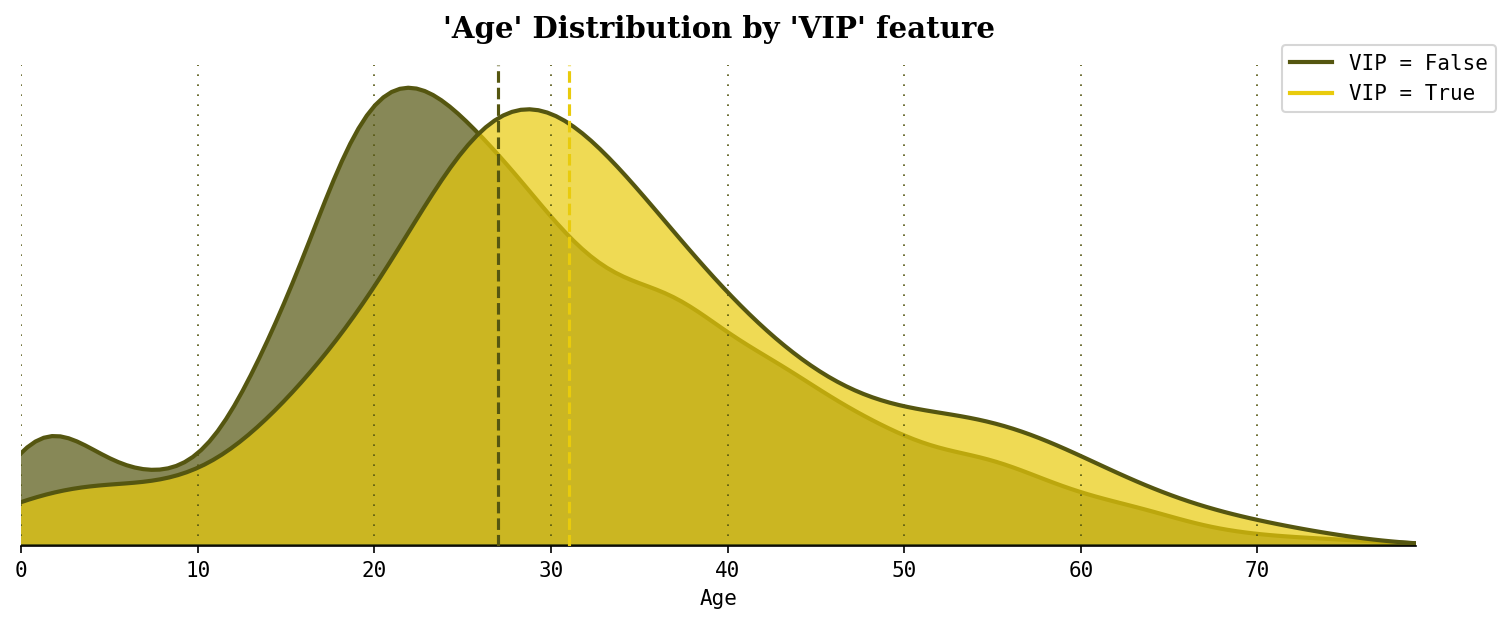

In [28]:
help.graph_by_group(df_EDA, group_variable="VIP", target_variables=["Age"])

So, there *are* VIP babies on board. Noted. Now, let's see how `VIP` status varies by `HomePlanet`. **Because maybe some planets are more prone to producing space VIPs.**

In [29]:
df_EDA.pivot_table(
	index="VIP",
	columns="HomePlanet",
	aggfunc="size",
	fill_value=0
)

HomePlanet  Earth  Europa  Mars
VIP                            
False        4487    1958  1653
True          115     173   106

The `VIP` feature isn't revealing any obvious imputation clues based on the home planet or other readily available groupings. **We're leaving `VIP` imputation alone for now. It can stay mysterious.**

In [30]:
manual_impute = help.TitanicNaNImputer()
df_EDA = manual_impute.fit_transform(df_EDA)

Time to apply all those imputation strategies we discussed and see if we can reduce the number of rows with missing values. **Let's see if our detective work pays off.**

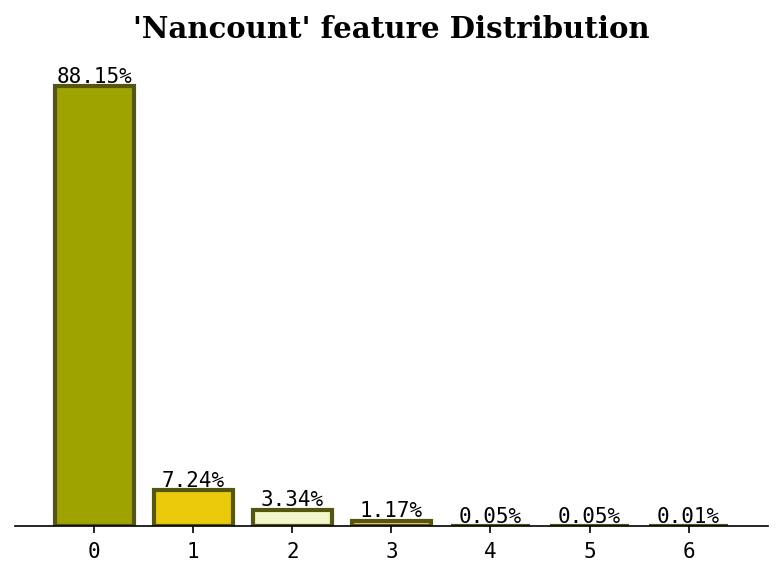

In [31]:
df_EDA["NaNCount"] = df_EDA.isna().sum(axis=1)

help.barcharts_by_group(df_EDA, target_variables=["NaNCount"])

Our manual imputations reclaimed 6.35% of rows with missing values. **Not bad for detective work.**  For the remaining NaNs, we'll bring in the automated imputation methods.  Time to let the algorithms do their thing.

Now, we'll attempt to impute missing *numerical* data using the MICE (Multiple Imputation by Chained Equations) method. **Because even numbers deserve some imputation love.**

In [32]:
numerical_features = ["Age", "RoomService",
                      "FoodCourt", "ShoppingMall",
                      "Spa", "VRDeck", "TotalSpend"]

numerical_impute = help.NUMMiceImputer(numerical_features=numerical_features,
                                       max_iter=5,
                                       random_state=42,
                                       verbose=1,
                                       estimator=RandomForestRegressor(),
                                       no_inference=False
                                       )
data_to_train = numerical_impute.fit_transform(df_EDA)

MICE Imputation:   0%|          | 0/5 [00:00<?, ?iter/s]

Now that we've (hopefully) filled in some missing `Age` values, it's time to recalculate the `AgeGroup` feature based on the updated ages. **Because age groups depend on, well, *age*.**

In [33]:
data_to_train = bin_age.fit_transform(data_to_train)

In [34]:
data_to_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   PassengerId     8693 non-null   object  
 1   HomePlanet      8691 non-null   object  
 2   CryoSleep       8693 non-null   bool    
 3   Destination     8511 non-null   category
 4   Age             8693 non-null   float64 
 5   VIP             8693 non-null   bool    
 6   RoomService     8693 non-null   float64 
 7   FoodCourt       8693 non-null   float64 
 8   ShoppingMall    8693 non-null   float64 
 9   Spa             8693 non-null   float64 
 10  VRDeck          8693 non-null   float64 
 11  Transported     8693 non-null   bool    
 12  Group           8693 non-null   object  
 13  GroupNum        8693 non-null   category
 14  CabinDeck       8494 non-null   category
 15  CabinNumber     8494 non-null   object  
 16  Side            8594 non-null   object  
 17  FirstName     

Time to reassess our imputation strategy. **Let's see if there are any more obvious manual imputations we can do before resorting to more complex methods.**

In [35]:
help.display_repeated_values(data_to_train, ["CabinDeck",
                                             "CabinNumber",
                                             "Side",
                                             "HomePlanet",
                                             "Destination",
                                             "VIP"])

Repeated values in 'CabinDeck':


CabinDeck  count
0         F   2794
1         G   2559
2         E    876
3         B    779
4         C    747

Repeated values in 'CabinNumber':


CabinNumber  count
0          82     28
1          86     22
2          19     22
3          56     21
4         176     21

Repeated values in 'Side':


Side  count
0    S   4343
1    P   4251

Repeated values in 'HomePlanet':


HomePlanet  count
0      Earth   4675
1     Europa   2161
2       Mars   1787
3    Unknown     68

Repeated values in 'Destination':


Destination  count
0    TRAPPIST-1e   5915
1    55 Cancri e   1800
2  PSO J318.5-22    796

Repeated values in 'VIP':


VIP  count
0  False   8291
1   True    402

`CabinNumber` is looking suspiciously high-cardinality. Let's confirm that suspicion. **Because too many unique values can be a problem.**

In [36]:
data_to_train["CabinNumber"].nunique()

1817

`CabinNumber` gets the simple KNN imputation treatment. For the remaining stubborn numerical features, we'll bring out the big guns: Gradient Boosting. **Because different features require different levels of imputation finesse.**

Next, we'll use Gradient Boosting to impute missing *categorical* data, using a *massive* list of features: `HomePlanet`, `Destination`, `Side`, `CabinNumber`, `CabinDeck`, `TravellingSolo`, `CryoSleep`, `AgeGroup`, and `VIP`. **That was a mouthful. Let's hope it's worth it.**

In [37]:
category_features = [
	"CabinDeck",
	"Side",
	"HomePlanet",
	"Destination",
	"VIP"
]

feature_columns_for_prediction_dict = {
	"CabinDeck"  : ["HomePlanet", "Destination", "Side", "VIP", "AgeGroup", "CryoSleep", "TravellingSolo"],
	"Side"       : ["HomePlanet", "Destination", "CabinDeck", "VIP", "AgeGroup", "CryoSleep", "TravellingSolo"],
	"HomePlanet" : ["Destination", "Side", "CabinDeck", "VIP", "AgeGroup", "CryoSleep", "TravellingSolo"],
	"Destination": ["HomePlanet", "Side", "CabinDeck", "VIP", "AgeGroup", "CryoSleep", "TravellingSolo"],
	"VIP"        : ["HomePlanet", "Destination", "Side", "CabinDeck", "AgeGroup", "CryoSleep", "TravellingSolo"]
}

categorical_impute = help.CATMiceImputer(categorical_features=category_features
                                         , features_cols_dict=feature_columns_for_prediction_dict,
                                         n_iterations=5,
                                         max_iter_estimator=50,
                                         estimator_type="gb")

data_to_train = categorical_impute.fit_transform(data_to_train)

MICE Imputation (GB):   0%|          | 0/5 [00:00<?, ?it/s]

Finally, we tackle the last high-cardinality categorical column.  We'll use the relatively simple Most Frequent imputation method. **Because sometimes, even for complex problems, the simple approach is good enough. Or at least, we're tired of complicated methods.**

In [38]:
categorical_impute2 = help.CATBasicImputer(["CabinNumber"])
data_to_train = categorical_impute2.fit_transform(data_to_train)

In [39]:
data_to_train["CabinNumber"].isna().sum()

0


After all that data wrangling and imputation, the data *should* (hopefully!) be clean. **Fingers crossed we didn't introduce *more* problems.**  What a relief. (Maybe.)

In [40]:
data_to_train.drop(["NaNCount"], axis=1, inplace=True)
data_to_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   PassengerId     8693 non-null   object  
 1   HomePlanet      8693 non-null   object  
 2   CryoSleep       8693 non-null   bool    
 3   Destination     8693 non-null   category
 4   Age             8693 non-null   float64 
 5   VIP             8693 non-null   bool    
 6   RoomService     8693 non-null   float64 
 7   FoodCourt       8693 non-null   float64 
 8   ShoppingMall    8693 non-null   float64 
 9   Spa             8693 non-null   float64 
 10  VRDeck          8693 non-null   float64 
 11  Transported     8693 non-null   bool    
 12  Group           8693 non-null   object  
 13  GroupNum        8693 non-null   category
 14  CabinDeck       8693 non-null   category
 15  CabinNumber     8693 non-null   object  
 16  Side            8693 non-null   object  
 17  FirstName     

**Sweet mother of ******, that's done.**  Data cleaning.  It's like wrestling a greased octopus covered in excrement.

Time to examine feature correlations with the `Transported` variable. **Let's see which factors might predict a one-way ticket to another dimension.**

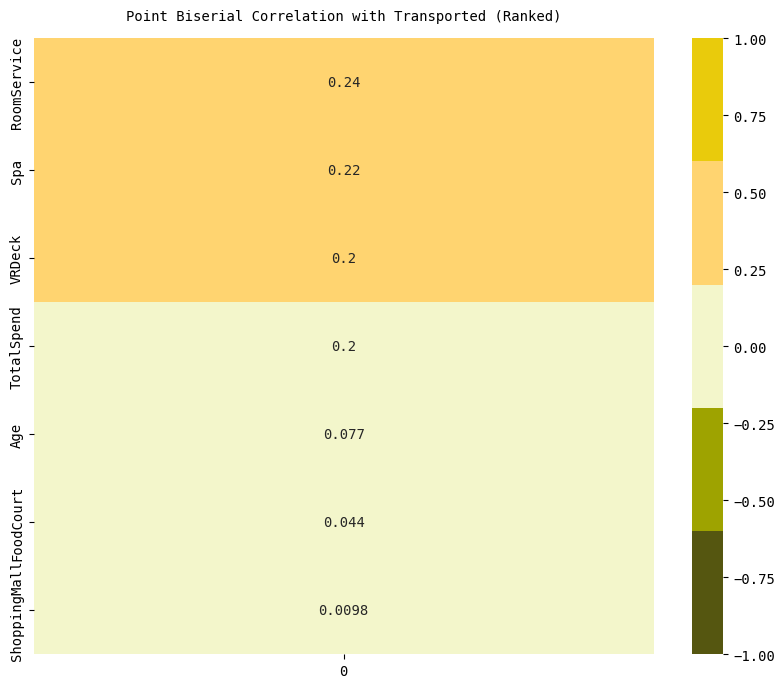

In [41]:
help.binary_heatmap(data_to_train, "Transported")

This heatmap shows the Point Biserial Correlation with `Transported`. Let's recap:

*   **`RoomService`, `Spa`, `VRDeck`, `TotalSpend`:** Positive correlation (~0.2). **Spend more, *slightly* higher chance of getting zapped.** My "spend to stay" hypothesis is looking shaky. Maybe it's non-linear, or maybe the correlation's just weak.
*   **`Age`:** Weak positive correlation (0.077). Older = *slightly* more transportable.
*   **`FoodCourt`:**  Pathetic positive correlation (0.044).  Insignificant.
*   **`ShoppingMall`:**  Basically zero (0.0098). **Shopping habits are utterly irrelevant to interdimensional travel.**

**Heatmap Conclusion:** Luxury spending has a *slight* positive correlation with getting transported. The rest is statistical noise.  Hardly a revelation.

---
# statistical-inference

Time to draw some *probably* overblown conclusions from the data. **Let the statistical hand-waving commence!**

**Target population**: 8,693 Titanic Starship passengers. 

**Significance level (Î±)**: 0.05. *Because tradition, mostly.*

**H1 (Null):** `CryoSleep` makes *no* difference to being transported.  Frozen or not, same odds.

**H1 (Alternative):** `CryoSleep` *does* affect transport probability.  Frozen and not frozen have different odds. **Basically, does being a popsicle influence your dimension-hopping chances?**

In [42]:
help.categorical_feature_tests(data_to_train, "CryoSleep", "Transported")

### Categorical Feature Test Results for: `CryoSleep` vs `Transported`

**Chi-Squared Test:**

* Chi-Squared Statistic: 1772.135

* p-value: 0.000

**Significant association found (p < 0.05)**

**Cramer's V:** 0.452

**H2 (Null):**  Origin planet doesn't matter for getting transported. All planets, same odds.

**H2 (Alternative):** Origin planet *does* matter.  Different planets, different transport probabilities. **Does where you're from influence your chances of a surprise dimension shift?**

In [43]:
help.categorical_feature_tests(data_to_train, "HomePlanet", "Transported")

### Categorical Feature Test Results for: `HomePlanet` vs `Transported`

**Chi-Squared Test:**

* Chi-Squared Statistic: 333.911

* p-value: 0.000

**Significant association found (p < 0.05)**

**Cramer's V:** 0.196

**H3 (Null):** Destination planet doesn't affect transport probability. All destinations, same odds.

**H3 (Alternative):** Destination *does* matter. Different destinations, different transport probabilities. **Does where you're *going* influence your chances of getting lost along the way?**

In [44]:
help.categorical_feature_tests(data_to_train, "Destination", "Transported")

### Categorical Feature Test Results for: `Destination` vs `Transported`

**Chi-Squared Test:**

* Chi-Squared Statistic: 99.174

* p-value: 0.000

**Significant association found (p < 0.05)**

**Cramer's V:** 0.107

**H4 (Null):** VIP status has *no* effect on transport probability. VIP or not, same odds.

**H4 (Alternative):** VIP status *does* matter. VIPs and non-VIPs have different transport probabilities. **Does paying extra for space-luxe treatment affect your dimensional fate?**

In [45]:
help.categorical_feature_tests(data_to_train, "VIP", "Transported")

### Categorical Feature Test Results for: `VIP` vs `Transported`

**Chi-Squared Test:**

* Chi-Squared Statistic: 5.030

* p-value: 0.025

**Significant association found (p < 0.05)**

**Cramer's V:** 0.024

**H5 (Null):** Group size has *no* effect on transport probability. Big group, small group â€“ same odds.

**H5 (Alternative):** Group size *does* matter. Different group sizes, different transport probabilities. **Does traveling with a crowd influence your dimensional fate?**

In [46]:
help.categorical_feature_tests(data_to_train, "GroupSize", "Transported")

### Categorical Feature Test Results for: `GroupSize` vs `Transported`

**Chi-Squared Test:**

* Chi-Squared Statistic: 145.282

* p-value: 0.000

**Significant association found (p < 0.05)**

**Cramer's V:** 0.129

**H6 (Null):** Traveling solo has *no* effect on transport probability.  Solo or with others â€“ same odds.

**H6 (Alternative):** Traveling solo *does* matter.  Solo travelers have different transport probabilities than those traveling with others. **Does being a lone wolf in space affect your chances of getting zapped?**

In [47]:
help.categorical_feature_tests(data_to_train, "TravellingSolo", "Transported")

### Categorical Feature Test Results for: `TravellingSolo` vs `Transported`

**Chi-Squared Test:**

* Chi-Squared Statistic: 112.104

* p-value: 0.000

**Significant association found (p < 0.05)**

**Cramer's V:** 0.114

**H7 (Null):** Spending zero has *no* effect on transport probability. Spenders and non-spenders â€“ same odds.

**H7 (Alternative):** Spending zero *does* matter.  Non-spenders have different transport probabilities than spenders. **Does being a tightwad in space affect your chances of a dimensional detour?**

In [48]:
help.categorical_feature_tests(data_to_train, "ZeroSpend", "Transported")

### Categorical Feature Test Results for: `ZeroSpend` vs `Transported`

**Chi-Squared Test:**

* Chi-Squared Statistic: 2014.529

* p-value: 0.000

**Significant association found (p < 0.05)**

**Cramer's V:** 0.481

**H8 (Null):** `CabinDeck` has *no* effect on transport probability. All decks, same odds.

**H8 (Alternative):** `CabinDeck` *does* matter. Different decks, different transport probabilities. **Does your cabin's location on the ship influence your chances of a dimensional detour?**

In [49]:
help.categorical_feature_tests(data_to_train, "CabinDeck", "Transported")

### Categorical Feature Test Results for: `CabinDeck` vs `Transported`

**Chi-Squared Test:**

* Chi-Squared Statistic: 392.270

* p-value: 0.000

**Significant association found (p < 0.05)**

**Cramer's V:** 0.212

**H9 (Null):** Cabin `Side` (Port or Starboard) has *no* effect on transport probability.  Either side, same odds.

**H9 (Alternative):** Cabin `Side` *does* matter.  Different sides, different transport probabilities. **Does being on the Port or Starboard side of the ship influence your chances of a dimensional detour?**

In [50]:
help.categorical_feature_tests(data_to_train, "Side", "Transported")

### Categorical Feature Test Results for: `Side` vs `Transported`

**Chi-Squared Test:**

* Chi-Squared Statistic: 93.401

* p-value: 0.000

**Significant association found (p < 0.05)**

**Cramer's V:** 0.104

**H10 (Null):** `AgeGroup` has *no* effect on transport probability. All age groups, same odds.

**H10 (Alternative):** `AgeGroup` *does* matter. Different age groups, different transport probabilities. **Does your age bracket influence your chances of a dimensional detour?**

In [51]:
help.categorical_feature_tests(data_to_train, "AgeGroup", "Transported")

### Categorical Feature Test Results for: `AgeGroup` vs `Transported`

**Chi-Squared Test:**

* Chi-Squared Statistic: 169.472

* p-value: 0.000

**Significant association found (p < 0.05)**

**Cramer's V:** 0.140

**H11(0):** Age distribution is the *same* for transported and non-transported passengers. (No difference).

**H11(a):** Age distribution is *different* for transported and non-transported passengers. (There *is* a difference).

Before testing the `Age` hypothesis, let's check if the `Age` distribution is normal. **Because, as we've learned, data rarely cooperates.**

In [52]:
help.shapiro_test_by_tag(data_to_train, "Transported",
                         "Age", display_output=True)

### Shapiro-Wilk Test Results:

**For Transported = True:**

* Test Statistic: 0.982

* P-value: 0.000

**For Transported = False:**

* Test Statistic: 0.973

* P-value: 0.000

Shapiro-Wilk tests screamed "non-normal!" (p-values = 0.000). We'll use non-parametric tests. **And, just for fun, let's *visualize* that non-normality with a QQ plot. Because confirmation bias is comforting.**

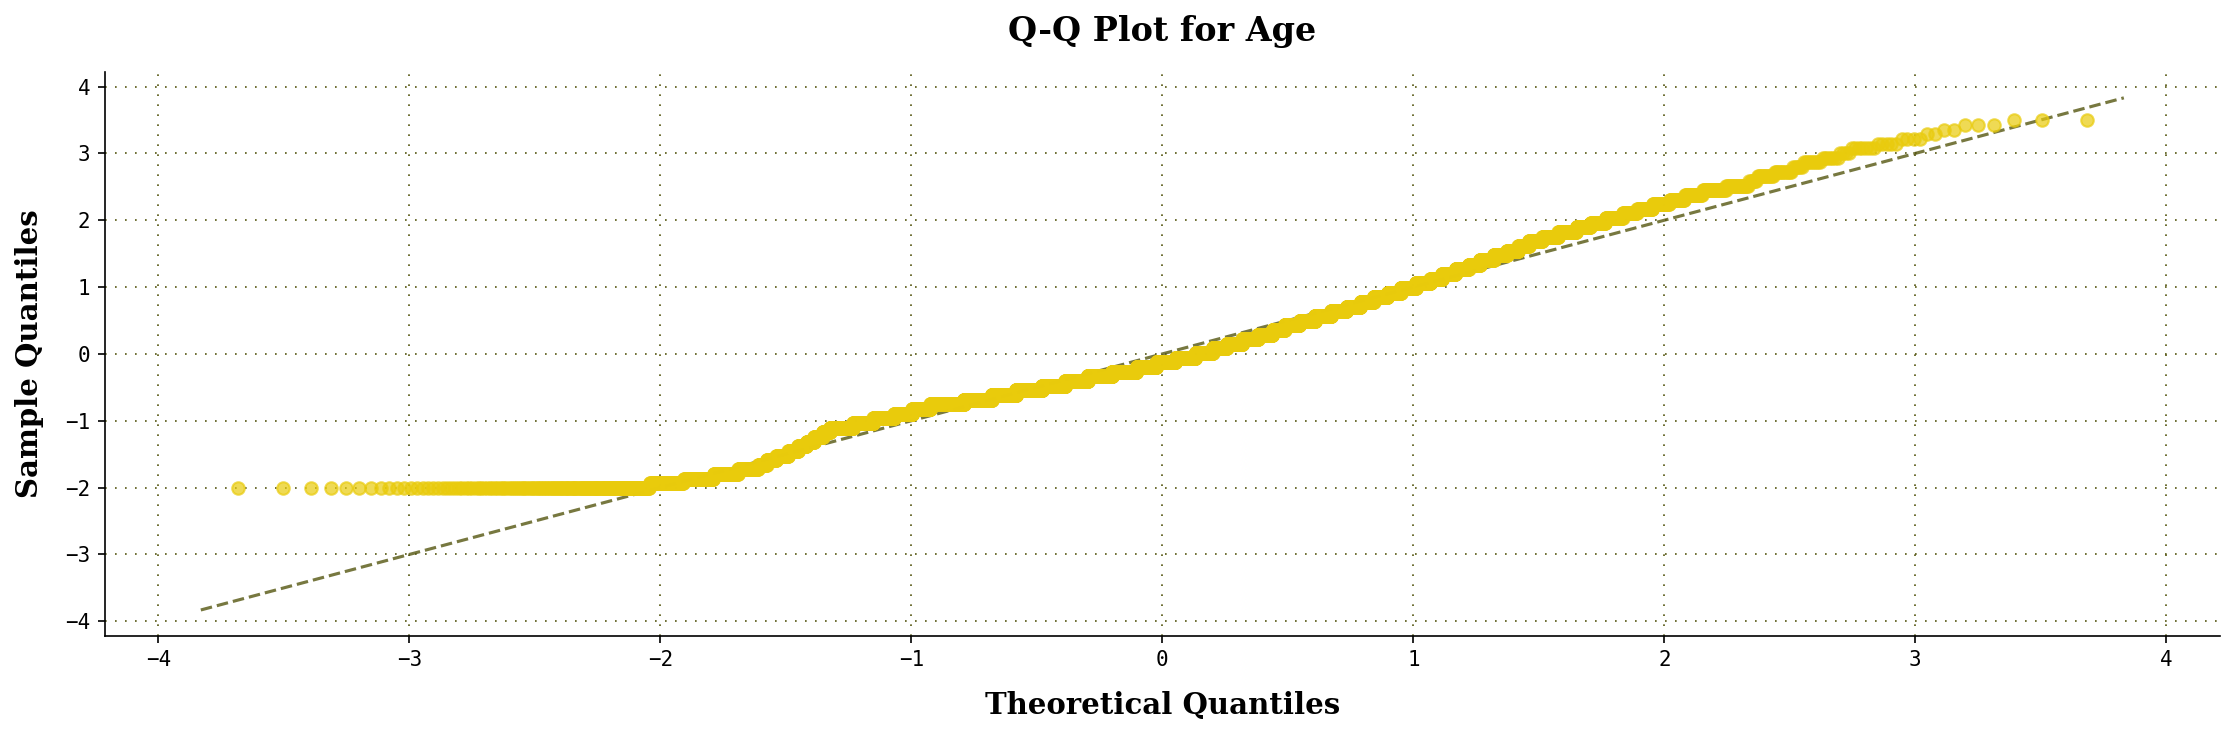

In [53]:
help.dynamic_qq(data_to_train, ["Age"])

Q-Q plot for `Age`: Middle's *mostly* normal. Tails deviate. Fewer very young, slightly older, than a perfect bell curve. **Slightly skewed, not horribly non-normal. Justifies those non-parametric tests.**

In [54]:
help.non_parametric_test_by_tag(data_to_train, "Transported",
                                "Age", display_output=True)

### Non-parametric Test Results (Mann-Whitney U) and Confidence Intervals:

**Confidence Level:** 95%

**For Transported = True:**

* Mean Value: 27.74

* Confidence Interval: (27.29, 28.18)

**For Transported = False:**

* Mean Value: 29.94

* Confidence Interval: (29.53, 30.34)

**Mann-Whitney U Test:**

* p-value = 0.000

**Statistical Summary: Who Gets Zapped and Why (Mostly)**

We ran a bunch of statistical tests (Chi-Squared for categorical variables, Mann-Whitney U for age) to figure out what factors influenced getting transported to another dimension on the Spaceship Titanic. Here's the breakdown, from *most* to *least* impactful:

**The Big Three (Strongest Associations):**

1.  **`ZeroSpend` (Cramer's V = 0.481, p-value = 0.000):** Spending *nothing* was the biggest predictor. **Be frugal, get zapped.**

2.  **`CryoSleep` (Cramer's V = 0.452, p-value = 0.000):** Being frozen was a close second. **Popsicles are prime teleportation candidates.**

3.  **`CabinDeck` (Cramer's V = 0.212, p-value = 0.000):** Where your room was located mattered, more than most other factors.

**The Measurable, but Less Important:**

4.  **`HomePlanet`** matters but less that the big three.
5.  **`Age` (Mann-Whitney U test: p-value = 0.000):** The age distributions *are* significantly different between the transported and not transported groups.  Mean age, transported: 27.73 (95% CI: 27.29â€“28.18).  Mean age, not transported: 29.93 (95% CI: 29.53â€“30.34). The non-overlapping confidence intervals provide further evidence. **Younger folks were *slightly* more likely to be transported.**

**The "Meh" Factors (Weak Associations, but still statistically significant):**

*   `AgeGroup` (Cramer's V = 0.140)
*   `GroupSize` (Cramer's V = 0.129)
*   `TravellingSolo` (Cramer's V = 0.114)
*   `Destination` (Cramer's V = 0.107)
*   `Side` (Cramer's V = 0.104)
*   `VIP` (Cramer's V = 0.024): Basically irrelevant.

**In short: To avoid an unexpected dimension hop, spend *something*, avoid cryosleep, and pick your cabin deck carefully. Age also plays a statistically significant, though less dramatic, role. Everything else is a minor detail.**

---
# data-preparation-and-preprocessing

This section details the steps taken to prepare the data for machine learning.  It's the "getting ready" montage before the main event.

In [55]:
pre_imputation_manipulation = Pipeline(
	steps=[
		("pid_split", transformers[0]),
		("cabin_splitter", transformers[1]),
		("name_slicer", transformers[2]),
		("group_assumptions", group_sizer),
		("expense_lumping", money_counter),
		("age_chunking", bin_age)
	])


In [56]:
imputation_ordeal = Pipeline(
	steps=[
		("educated_guesses", manual_impute),
		("number_extrapolation", numerical_impute),
		("age_grouping", bin_age),
		("category_imputation_1", categorical_impute),
		("category_imputation_2", categorical_impute2)
	]
)

In [57]:
full_pipeline = Pipeline(
	steps=[
		("pre_impute_fiddling", pre_imputation_manipulation),
		("imputation_and_more_fiddling", imputation_ordeal)
	]
)

**The Pipeline Circus: Overengineering 101**

We've created Rube Goldberg machine that turns data into... slightly different data. *Efficiency!*

In [58]:
X = data_to_train.copy()

X.drop(["PassengerId"], axis=1, inplace=True)
y = X.pop("Transported")

In [59]:
numerical_cols = [
	cname for cname in X.columns if X[cname].dtype in ["int64", "float64"]
]
categorical_cols = [
	cname for cname in X.columns if X[cname].dtype in ["object", "bool", "category"]
]

In [60]:
numerical_transformer = Pipeline(steps=[("scaler", StandardScaler())])

categorical_transformer = Pipeline(
	steps=[("categorical", OneHotEncoder(handle_unknown="ignore"))]
)

preprocessor = ColumnTransformer(
	transformers=[
		("numerical", numerical_transformer, numerical_cols),
		("categorical", categorical_transformer, categorical_cols),
	],
)

In [61]:
X_Train = preprocessor.fit_transform(X)

**Pipeline Summary: Data Wrangling in Action**

This code processes raw data into a machine-learning-friendly format by splitting columns, scaling numbers, encoding categories, and combining everything into a single preprocessor. The result? Data that's ready to be shoved into yet another pipeline. *Because why stop at one?*

## model-evaluation
___

In [62]:
CBM_clf_basic = CatBoostClassifier(random_state=42, verbose=False)
CBM_clf_basic.fit(X_Train, y)

CBM_predictions = CBM_clf_basic.predict(X_Train)

print(classification_report(y, CBM_predictions))

              precision    recall  f1-score   support

       False       0.85      0.82      0.84      4315
        True       0.83      0.86      0.84      4378

    accuracy                           0.84      8693
   macro avg       0.84      0.84      0.84      8693
weighted avg       0.84      0.84      0.84      8693



**CatBoost: The "First Date" Disappointment**

We slapped an untuned, basic CatBoost model on our Train data, skipping cross-validation because why bother?

- **Accuracy**: 84% â€“ looks good, but might be a fluke.
- **Scores**: All ~0.84 â€“ consistently average.

*TL;DR*: Works on Train data with a vanilla model. Real-world? TBD.

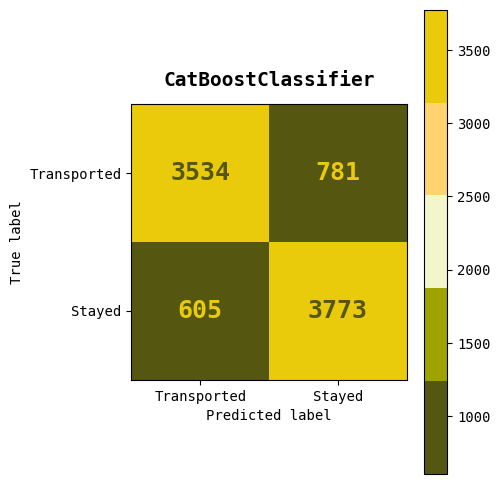

In [63]:
help.dynamic_confusion_matrix(models=[CBM_clf_basic],
                              X=X_Train, y=y, display_labels=["Transported", "Stayed"])

**Confusion Matrix: XGBoost's Snapshot**

- **Hits**: 3534 (Transported), 3773 (Stayed) â€“ solid.
- **Misses**: 605 (FN), 781 (FP) â€“ untuned model vibes.

*TL;DR*: Decent, but errors suggest room for improvement.

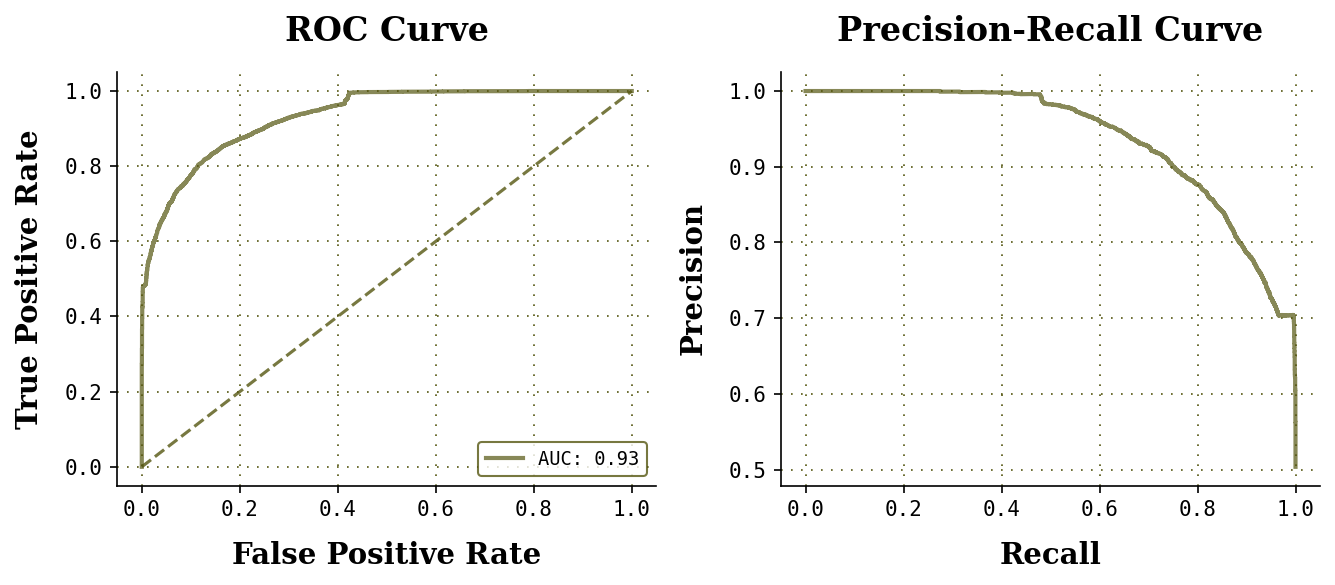

In [64]:
help.plot_model_evaluation(y, classifier=CBM_clf_basic, X=X_Train)

**Performance Snapshot: ROC & Precision-Recall Curves**

- **ROC Curve**: AUC = **0.93** â€“ solid discrimination, but not jaw-dropping.
- **Precision-Recall Curve**: High precision at most recall levels.

*TL;DR*: Good, but not perfect. Looks like the untuned model is holding its own... for now.


In [65]:
categorical_feature_names = (
	preprocessor.named_transformers_["categorical"]
	.named_steps["categorical"]
	.get_feature_names_out(categorical_cols)
)
feature_names = numerical_cols + categorical_feature_names.tolist()

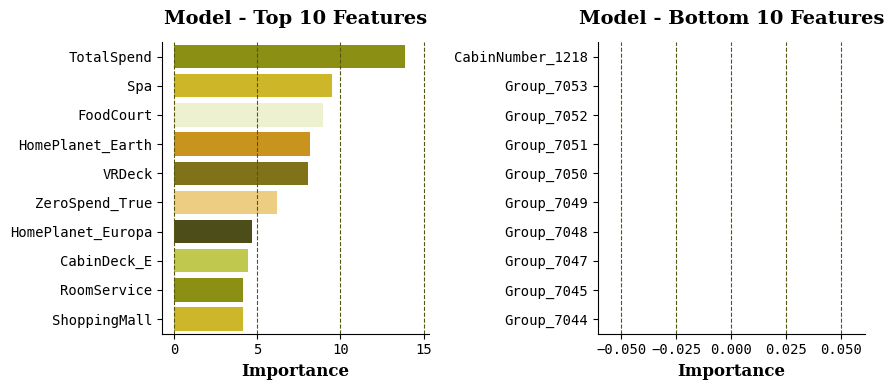

In [66]:
help.feature_importances(
	model=CBM_clf_basic,
	feature_names=feature_names,
)

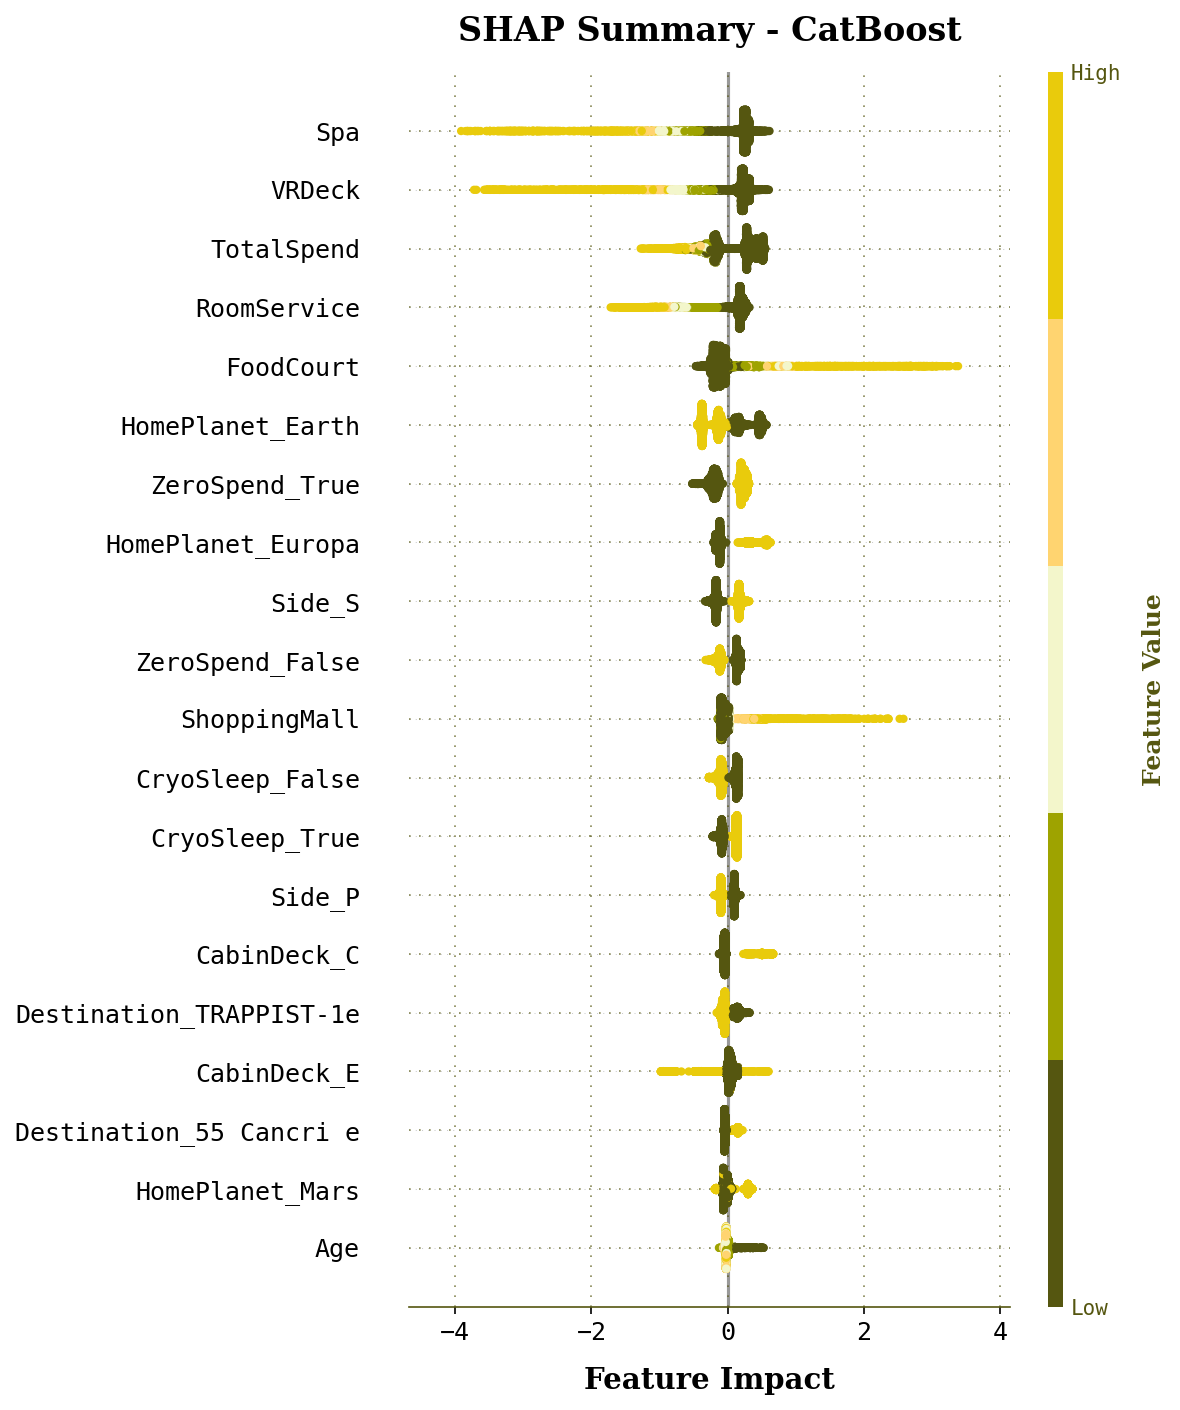

In [67]:
help.shap_summary(
	model=CBM_clf_basic,
	X=X_Train.toarray(),
	feature_names=feature_names,
	model_name="CatBoost"
)

**High Cardinality: The Feature Overload**

The attached visuals scream *"too many high cardinality features"*:

- **Top Features**: Spending-related features dominate (Spa, TotalSpend, VRDeck). High cardinality culprits like `CabinNumber` and `Group` contribute nothing.
- **SHAP Summary**: Spending habits and home planets matter most; other features barely move the needle.

*Plan*: Ditch high cardinality features (e.g., `CabinNumber`, `Group`) and test both versions on Kaggle. Let's see if less clutter boosts performance or just makes us regret everything.


In [68]:
X_2 = data_to_train.copy()
X_2.drop(["PassengerId", "CabinNumber", "Group",
          "FirstName", "LastName"], axis=1, inplace=True)
y_2 = X_2.pop("Transported")

test = pd.read_csv("../data/test.csv")
X_Test = test.copy()
X_Test_2 = test.copy()

X_Test = full_pipeline.transform(X_Test)
X_Test.drop(["PassengerId"], axis=1, inplace=True)

X_Test_2 = full_pipeline.transform(X_Test_2)
X_Test_2.drop(["PassengerId", "CabinNumber", "Group",
               "FirstName", "LastName"], axis=1, inplace=True)

MICE Imputation:   0%|          | 0/5 [00:00<?, ?iter/s]

MICE Imputation (GB):   0%|          | 0/5 [00:00<?, ?it/s]

MICE Imputation:   0%|          | 0/5 [00:00<?, ?iter/s]

MICE Imputation (GB):   0%|          | 0/5 [00:00<?, ?it/s]

we decided to drop `PassengerId`, `CabinNumber`, `Group`, `FirstName`, `LastName`. This will also help us to test the models faster and apply a more wide hyperparameter space.

In [69]:
numerical_cols_2 = [
	cname for cname in X_2.columns if X_2[cname].dtype in ["int64", "float64"]
]
categorical_cols_2 = [
	cname for cname in X_2.columns if X_2[cname].dtype in ["object", "bool", "category"]
]

In [70]:
numerical_transformer = Pipeline(steps=[("scaler", StandardScaler())])

categorical_transformer = Pipeline(
	steps=[("categorical", OneHotEncoder(handle_unknown="ignore"))]
)

preprocessor_2 = ColumnTransformer(
	transformers=[
		("numerical", numerical_transformer, numerical_cols_2),
		("categorical", categorical_transformer, categorical_cols_2),
	],
)

In [71]:
X_Train_2 = preprocessor_2.fit_transform(X_2)

X_Test = preprocessor.transform(X_Test)
X_Test_2 = preprocessor_2.transform(X_Test_2)

**Repipeline: Dropped Columns**

- **Numerical**: Scaled with `StandardScaler`.
- **Categorical**: Encoded with `OneHotEncoder` (handling unknowns).
- **Preprocessor**: Combines both for clean, transformed data (`X_Train_2`, `X_Test_2`).

*TL;DR*: Dropped features, reprocessed data, ready for modeling.


In [72]:
classifiers = {
	"LogisticRegression": LogisticRegression(random_state=42),
	"RidgeClassifier"   : RidgeClassifier(random_state=42),

	"KNN"               : KNeighborsClassifier(),

	"DecisionTree"      : DecisionTreeClassifier(random_state=42),
	"RandomForest"      : RandomForestClassifier(random_state=42),
	"ExtraTrees"        : ExtraTreesClassifier(random_state=42),

	"GradientBoosting"  : GradientBoostingClassifier(random_state=42),
	"XGBoost"           : XGBClassifier(random_state=42),
	"LGBM"              : LGBMClassifier(random_state=42, verbose=-1),
	"CatBoost"          : CatBoostClassifier(random_state=42, verbose=False),

	"SVC"               : SVC(probability=False, random_state=42, cache_size=2000),
	"BernoulliNB"       : BernoulliNB(),

	"DummyClassifier"   : DummyClassifier(strategy="stratified", random_state=42)
}

LR_grid = {
	"C"       : [0.01, 0.1, 0.2, 0.25, 0.5, 0.75, 1, 1.25, 1.5,
	             2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
	"max_iter": [50, 100, 150, 200, 300, 400, 500, 600,
	             700, 800, 900, 1000],
	"penalty" : ["l1", "l2"],
	"solver"  : ["liblinear"]
}

RIDGE_grid = {
	"alpha"        : np.logspace(-3, 3, 20),
	"solver"       : ["auto"],
	"fit_intercept": [True, False],
	"tol"          : [1e-5, 1e-4, 1e-3, 1e-2],
	"class_weight" : [None, "balanced"],
	"max_iter"     : [100, 500, 1000, 2000]
}

KNN_grid = {
	"n_neighbors": list(range(1, 50)),
	"p"          : [1, 2, 3],
	"weights"    : ["uniform", "distance"],
	"metric"     : ["cityblock", "cosine", "euclidean", "l1", "l2", "manhattan"]
}

DT_grid = {
	"max_depth"        : list(range(3, 10)),
	"min_samples_split": list(range(2, 11)),
	"min_samples_leaf" : list(range(1, 11)),
	"criterion"        : ["gini", "entropy"]
}

RF_grid = {
	"n_estimators"     : list(range(50, 300, 2)),
	"max_depth"        : list(range(3, 10)),
	"min_samples_split": list(range(2, 20)),
	"min_samples_leaf" : list(range(1, 20)),
	"bootstrap"        : [True, False],
	"max_features"     : ["sqrt", "log2"]
}

ET_grid = {
	"n_estimators"     : list(range(50, 300, 2)),
	"max_depth"        : list(range(3, 10)),
	"min_samples_split": list(range(2, 20)),
	"min_samples_leaf" : list(range(1, 20)),
	"max_features"     : ["sqrt", "log2"]
}

GB_grid = {
	"n_estimators" : list(range(50, 300, 2)),
	"max_depth"    : list(range(3, 10)),
	"learning_rate": [0.01, 0.05, 0.1, 0.2],
	"subsample"    : [0.6, 0.8, 1.0],
	"max_features" : ["sqrt", "log2"]
}

XGB_grid = {
	"n_estimators"    : list(range(50, 300, 2)),
	"max_depth"       : list(range(3, 10)),
	"learning_rate"   : [0.01, 0.05, 0.1, 0.2],
	"gamma"           : [0, 0.1, 0.2],
	"subsample"       : [0.6, 0.8],
	"colsample_bytree": [0.6, 0.8],
	"reg_alpha"       : [0.01, 0.1],
	"reg_lambda"      : [1]
}

LGBM_grid = {
	"n_estimators"    : list(range(50, 300, 2)),
	"max_depth"       : list(range(3, 10)),
	"learning_rate"   : [0.01, 0.05, 0.1, 0.2],
	"num_leaves"      : [20, 31, 40],
	"subsample"       : [0.6, 0.8, 1.0],
	"colsample_bytree": [0.6, 0.8, 1.0],
	"verbose"         : [-1]
}

CBM_grid = {
	"n_estimators" : list(range(50, 300, 2)),
	"max_depth"    : list(range(1, 6)),
	"learning_rate": [0.01, 0.05, 0.1, 0.2],
	"subsample"    : [0.6, 0.8, 1.0],
	"rsm"          : [0.6, 0.8, 1.0]
}

SVC_grid = {
	"C"     : [0.01, 0.1, 0.2, 0.25, 0.5, 0.75, 1, 1.25, 1.5,
	           2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
	"gamma" : ["scale", "auto", 0.01, 0.1],
	"kernel": ["rbf", "poly", "sigmoid"],
	"degree": [2, 3, 4]
}

BNB_grid = {
	"alpha"   : np.logspace(-3, 1, 200),
	"binarize": [0.0, 0.25, 0.5, 0.75, 1.0]
}

DUMMY_grid = {
	"strategy"    : ["stratified", "most_frequent", "prior", "uniform"],
	"random_state": [None, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
	                 10, 20, 30, 42, 50, 100, 2025],
	"constant"    : [None, 0, 1, -1, 10, 100, 200, 300, 404, 400, 99, -99,
	                 999, -999, 9999, -9999, 99999, -99999]
}

grid = {
	"LogisticRegression": LR_grid,
	"RidgeClassifier"   : RIDGE_grid,

	"KNN"               : KNN_grid,

	"DecisionTree"      : DT_grid,
	"RandomForest"      : RF_grid,
	"ExtraTrees"        : ET_grid,

	"GradientBoosting"  : GB_grid,
	"XGBoost"           : XGB_grid,
	"LGBM"              : LGBM_grid,
	"CatBoost"          : CBM_grid,

	"SVC"               : SVC_grid,

	"BernoulliNB"       : BNB_grid,

	"DummyClassifier"   : DUMMY_grid
}

**Classifier Zoo: Overkill Edition**

Behold, an exhaustive parade of models and hyperparameters:

- **12 Classifiers**: From *basic LogisticRegression* to *overengineered CatBoost*. Because why choose one when you can drown in options?
- **Hyperparameter Grids**: So vast they make the Grand Canyon look cozy. Highlights include:
  - `KNN_grid` with **49 neighbors** and **6 distance metrics** (for maximum indecision).
  - `DUMMY_grid` with **18 random_states** â€“ because even incompetence needs options.
- **Optimization**: 10-fold CV with **500 random searches** per model. Your CPU's funeral is at 3 PM.

*TL;DR*: Throwing computational brute force at the wall to see what sticks. Spoiler: The DummyClassifier will still disappoint.


In [73]:
valid_scores, best_params, best_models = help.optimize_and_evaluate_classifiers(
	classifiers,
	grid,
	X_Train_2,
	y_2,
	n_iter_random_search=500,
	cv_folds=10
)

Model               Average Validation Accuracy (%)  Total Time (s)  Best Params


Optimizing Classifiers:   0%|          | 0/13 [00:00<?, ?it/s]

LogisticRegression:   0%|          | 0/500 [00:00<?, ?it/s]

LogisticRegression                               78.96%         151.75s{'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 50, 'C': 0.5}


RidgeClassifier:   0%|          | 0/500 [00:00<?, ?it/s]

RidgeClassifier                               77.45%          77.64s{'tol': 0.01, 'solver': 'auto', 'max_iter': 1000, 'fit_intercept': False, 'class_weight': None, 'alpha': 233.57214690901213}


KNN:   0%|          | 0/500 [00:00<?, ?it/s]

KNN                                           78.17%         212.01s{'weights': 'uniform', 'p': 3, 'n_neighbors': 25, 'metric': 'l2'}


DecisionTree:   0%|          | 0/500 [00:00<?, ?it/s]

DecisionTree                                  78.84%          85.11s{'min_samples_split': 2, 'min_samples_leaf': 10, 'max_depth': 9, 'criterion': 'gini'}


RandomForest:   0%|          | 0/500 [00:00<?, ?it/s]

RandomForest                                  79.36%         539.50s{'n_estimators': 180, 'min_samples_split': 18, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'max_depth': 9, 'bootstrap': False}


ExtraTrees:   0%|          | 0/500 [00:00<?, ?it/s]

ExtraTrees                                    75.57%         417.77s{'n_estimators': 66, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 9}


GradientBoosting:   0%|          | 0/500 [00:00<?, ?it/s]

GradientBoosting                               80.36%         981.11s{'subsample': 0.6, 'n_estimators': 212, 'max_features': 'log2', 'max_depth': 7, 'learning_rate': 0.05}


XGBoost:   0%|          | 0/500 [00:00<?, ?it/s]

XGBoost                                       80.69%         350.33s{'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0.01, 'n_estimators': 244, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.8}


LGBM:   0%|          | 0/500 [00:00<?, ?it/s]

LGBM                                          80.72%        5685.99s{'verbose': -1, 'subsample': 1.0, 'num_leaves': 20, 'n_estimators': 78, 'max_depth': 9, 'learning_rate': 0.2, 'colsample_bytree': 0.8}


CatBoost:   0%|          | 0/500 [00:00<?, ?it/s]

CatBoost                                      80.90%         633.44s{'subsample': 1.0, 'rsm': 0.8, 'n_estimators': 292, 'max_depth': 4, 'learning_rate': 0.1}


SVC:   0%|          | 0/500 [00:00<?, ?it/s]

SVC                                           80.00%        2155.76s{'kernel': 'rbf', 'gamma': 0.01, 'degree': 4, 'C': 80}


BernoulliNB:   0%|          | 0/500 [00:00<?, ?it/s]

BernoulliNB                                   74.39%          74.21s{'binarize': 0.75, 'alpha': 0.517092024289676}


DummyClassifier:   0%|          | 0/500 [00:00<?, ?it/s]

DummyClassifier                               51.22%          68.57s{'strategy': 'stratified', 'random_state': 3, 'constant': 99}


**Classifier Optimization Results: The Good, The Bad, and The Ugly**

### **Top Performers**
1. **CatBoostClassifier**:  
   - Accuracy: **80.90%**  
   - Params: `learning_rate=0.1`, `max_depth=4`, `n_estimators=292`  
   - *Fast, reliable, and loves categorical features.*

2. **XGBoostClassifier**:  
   - Accuracy: **80.69%**  
   - Params: `learning_rate=0.05`, `gamma=0.1`, `max_depth=6`, `n_estimators=244`  
   - *Slow learner but packs a punch.*

3. **LGBMClassifier**:  
   - Accuracy: **80.72%**  
   - Params: `learning_rate=0.2`, `max_depth=9`, `n_estimators=78`  
   - *Quick and efficient, but depth-heavy.*

4. **GradientBoostingClassifier**:  
   - Accuracy: **80.36%**  
   - Params: `learning_rate=0.07`, `max_depth=7`, `n_estimators=212`  
   - *Solid performer but slower than the rest.*

### **Middle of the Pack**
- **SVC**: Accuracy: **80.00%** â€“ Reliable but resource-intensive.
- **RandomForestClassifier**: Accuracy: **79.36%** â€“ Classic ensemble, still strong.
- **DecisionTreeClassifier**: Accuracy: **78.84%** â€“ Simple and interpretable.

### **Underperformers**
- **BernoulliNB**: Accuracy: **74.21%** â€“ Struggles with complex datasets.
- **DummyClassifier**: Accuracy: **51.22%** â€“ *Why even bother?*


*TL;DR*: CatBoost leads the pack, followed closely by XGBoost and LGBM. Gradient Boosting holds its own, while simpler models like Decision Trees and Random Forests remain dependable options.


In [74]:
best_classifiers: List[ClassifierMixin] = []
classifier_names = ["LGBM", "CatBoost", "XGBoost", "LogisticRegression"]

classifier_classes: Dict[str, type] = {
	"LGBM"              : LGBMClassifier,
	"CatBoost"          : CatBoostClassifier,
	"XGBoost"           : XGBClassifier,
	"LogisticRegression": LogisticRegression
}

for classifier_name in classifier_names:
	classifier_class = classifier_classes[classifier_name]
	params = best_params[classifier_name]

	if classifier_name == "CatBoost":
		best_classifiers.append(classifier_class(**params, verbose=False, random_state=0))
	else:
		best_classifiers.append(classifier_class(**params, random_state=0))

print("Best Classifiers List Created:")
for clf in best_classifiers:
	print(f"- {clf.__class__.__name__} (params: {clf.get_params()})")

Best Classifiers List Created:
- LGBMClassifier (params: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.2, 'max_depth': 9, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 78, 'n_jobs': None, 'num_leaves': 20, 'objective': None, 'random_state': 0, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1})
- CatBoostClassifier (params: {'learning_rate': 0.1, 'rsm': 0.8, 'verbose': False, 'subsample': 1.0, 'max_depth': 4, 'n_estimators': 292, 'random_state': 0})
- XGBClassifier (params: {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'feature_weights': None, 'gamma': 0.1, 'grow_p

!**The "Best" Models: A Symphony of Overengineering**

Let's dissect our questionable champions:

1. **LGBMClassifier**  
   - `learning_rate`: 0.2 (need for speed)  
   - `max_depth`: 9 (deeper than Titanic's wreck)  
   - `n_estimators`: 78 (prime number supremacy)  
   - `subsample`: 1.0 ("I trust my data completely" energy)  

2. **CatBoostClassifier**  
   - `rsm`: 0.8 (random subspace maximalism)  
   - `max_depth`: 4 (shallow but opinionated)  
   - `n_estimators`: 292 ("I stopped when I got bored" logic)  

3. **XGBoost**  
   - `gamma`: 0.1 (minimum effort threshold)  
   - `learning_rate`: 0.05 (glacial pace)  
   - `n_estimators`: 244 (why stop at 250?)  

4. **LogisticRegression**  
   - `penalty`: l1 (sparsity fetish)  
   - `C`: 0.5 ("I'm kind of regularized, I guess?")  
   - `max_iter`: 50 (convergence is a myth)  

*TL;DR*: We've created models so specific, they probably only work on Tuesdays. Kaggle submission = reality check incoming.


In [75]:
stacking_clf = StackingClassifier(
	estimators=[
		("LGBM", best_classifiers[0]),
		("CatBoost", best_classifiers[1]),
		("XGBoost", best_classifiers[2]),
	],
	final_estimator=best_classifiers[3],
)

stacking_classifiers = {
	"StackingEnsemble": stacking_clf
}

stacking_grid = {
	"StackingEnsemble": {
		"final_estimator__C"           : [0.01, 0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 10.0],
		"final_estimator__max_iter"    : [100, 200, 300, 400, 500],
		"final_estimator__solver"      : ["liblinear"],
		"final_estimator__penalty"     : ["l1", "l2"],
		"final_estimator__class_weight": [None, "balanced"],
		"stack_method"                 : ["auto", "predict_proba"],
		"passthrough"                  : [False, True],
		"n_jobs"                       : [1]
	}
}

**Stacking Ensemble: Because One Model Wasn't Enough**

We're now stacking our three tree-based overachievers (LGBM, CatBoost, XGBoost) and letting *LogisticRegression* play referee. Because nothing says "ensemble" like duct-taping models together:

- **Base Models**: Tree trio that already gave us ~80% accuracy.
- **Meta-Model**: The same LogisticRegression we barely tuned. *What could go wrong?*
- **Hyperparameter Grid**:  
  - `C`: [0.01 to 10.0] â€“ covering everything from timid to reckless.  
  - `max_iter`: [100-500] â€“ because patience is a virtue (or a CPU crime).  
  - `stack_method`: ["auto", "predict_proba"] â€“ SchrÃ¶dinger's stacking.  

*TL;DR*: If at first you don't succeed, throw more models at it. Ensemble magic or computational dumpster fire? Kaggle will decide.


In [76]:
stacking_scores, stacking_best_params, stacking_best_model = help.optimize_and_evaluate_classifiers(
	classifiers=stacking_classifiers,
	grid=stacking_grid,
	X=X_Train_2,
	y=y_2,
	n_iter_random_search=100,
	cv_folds=10,
	scoring_metric="accuracy",
	random_state=42
)

Model               Average Validation Accuracy (%)  Total Time (s)  Best Params


Optimizing Classifiers:   0%|          | 0/1 [00:00<?, ?it/s]

StackingEnsemble:   0%|          | 0/100 [00:00<?, ?it/s]

StackingEnsemble                               80.81%        4413.63s{'stack_method': 'predict_proba', 'passthrough': False, 'n_jobs': 1, 'final_estimator__solver': 'liblinear', 'final_estimator__penalty': 'l1', 'final_estimator__max_iter': 500, 'final_estimator__class_weight': None, 'final_estimator__C': 0.01}


**Stacking Ensemble Results: 1 Hour for a 0.09% drop**

- **Validation Accuracy**: **80.81%** â€“ a slight **0.09% decrease** over individual models.
- **Best Params**:
  - `stack_method`: "predict_proba" â€“ because probabilities are fancy.
  - `final_estimator__penalty`: "l1" â€“ regularization saves the day.
  - `final_estimator__C`: 0.01 â€“ timid, but effective.
  - `max_iter`: 500 â€“ because convergence takes time.

*TL;DR*: After about 1.5 hours of optimization, we did no get any increase, which is... *sad*. At least the progress bar looked cool.


In [77]:
stacking_clf = stacking_best_model["StackingEnsemble"].fit(X_Train_2, y_2)
stacking_predictions = stacking_clf.predict(X_Train_2)

print(classification_report(y_2, stacking_predictions))

              precision    recall  f1-score   support

       False       0.87      0.82      0.84      4315
        True       0.83      0.88      0.86      4378

    accuracy                           0.85      8693
   macro avg       0.85      0.85      0.85      8693
weighted avg       0.85      0.85      0.85      8693



In [78]:
CBM_clf = CatBoostClassifier(**best_params["CatBoost"],
                             random_state=42, verbose=False)
CBM_clf.fit(X_Train_2, y_2)

CBM_predictions = CBM_clf.predict(X_Train_2)

print(classification_report(y_2, CBM_predictions))

              precision    recall  f1-score   support

       False       0.85      0.82      0.83      4315
        True       0.83      0.86      0.84      4378

    accuracy                           0.84      8693
   macro avg       0.84      0.84      0.84      8693
weighted avg       0.84      0.84      0.84      8693



**Stacking vs CatBoost: F1-Score Showdown**

- **Stacking Ensemble**:
  - Accuracy: **0.85**
  - F1-Score: **0.85** (macro avg) â€“ consistent across classes, but recall for "True" class excels at **0.88**.

- **CatBoost**:
  - Accuracy: **0.84**
  - F1-Score: **0.84** (macro avg) â€“ slightly lower.

*TL;DR*: Stacking edges out slightly on F1-score,so it should probably be more reliable in real-world scenarios. Time for Kaggle to decide the winner.

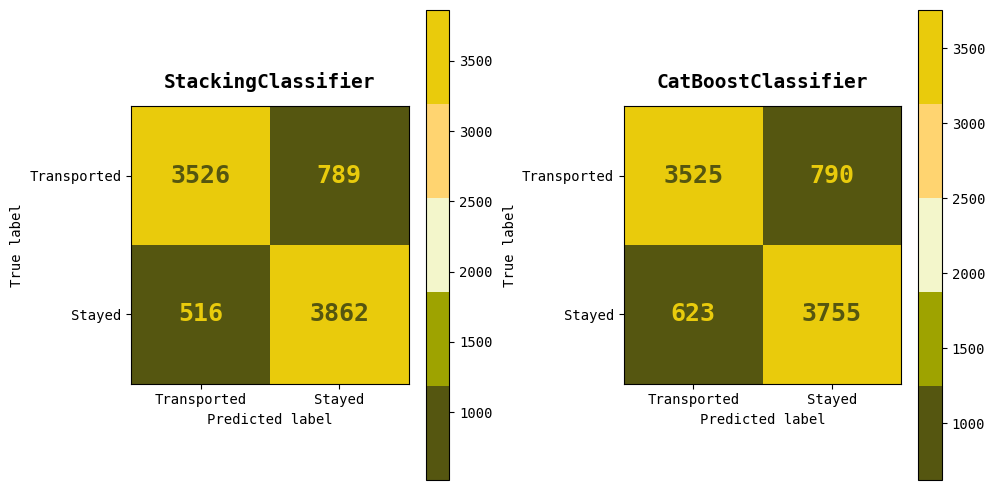

In [79]:
help.dynamic_confusion_matrix(models=[stacking_clf, CBM_clf],
                              X=X_Train_2, y=y_2, display_labels=["Transported", "Stayed"])

**Confusion Matrix Comparison**

- **StackingClassifier**: Slightly better on Train data with fewer False Positives (518 vs. 623).
- **CatBoostClassifier**: Almost invisible higher True Positives (3525 vs. 3526).

*TL;DR*: StackingClassifier edges out CatBoost in overall accuracy on Train data.

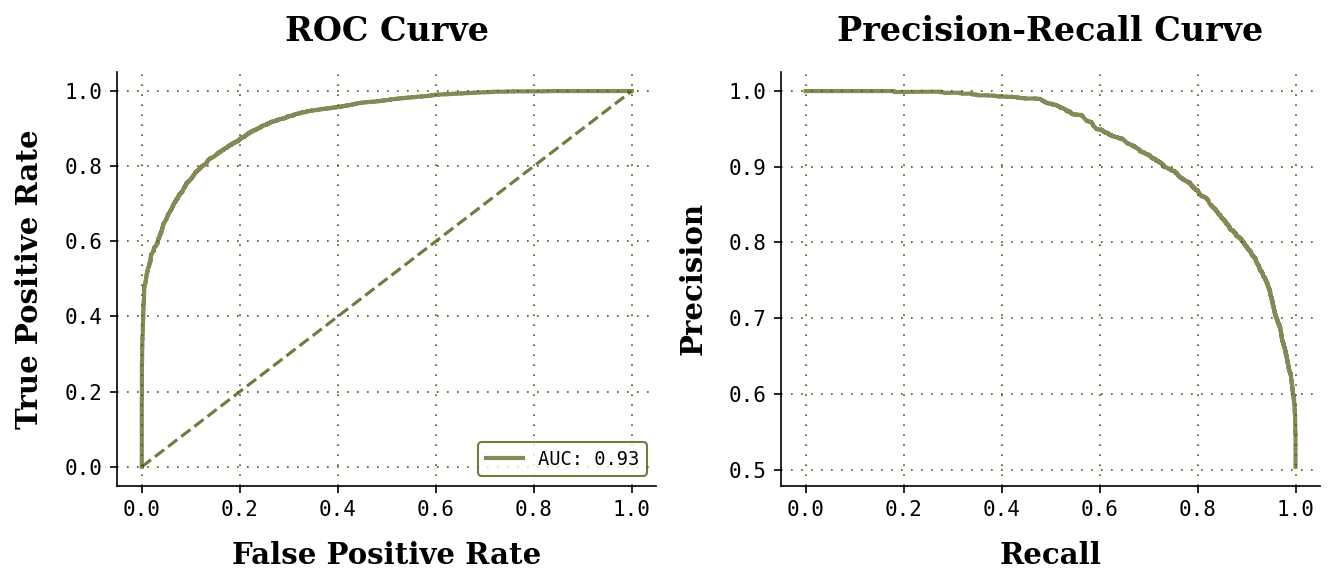

In [80]:
help.plot_model_evaluation(y_2, classifier=CBM_clf, X=X_Train_2)

**ROC & Precision-Recall Curve: CatBoost Evaluation**

- **ROC AUC**: **0.93** â€“ solid, but it's the same as the basic CatBoost model. although there are no sharp lines here.
- **Precision-Recall**: High precision across recall levels.

*TL;DR*: Strong performance, but the similar AUC is unlikely to be a game-changer.


In [81]:
categorical_feature_names_2 = (
	preprocessor_2.named_transformers_["categorical"]
	.named_steps["categorical"]
	.get_feature_names_out(categorical_cols_2)
)
feature_names_2 = numerical_cols_2 + categorical_feature_names_2.tolist()

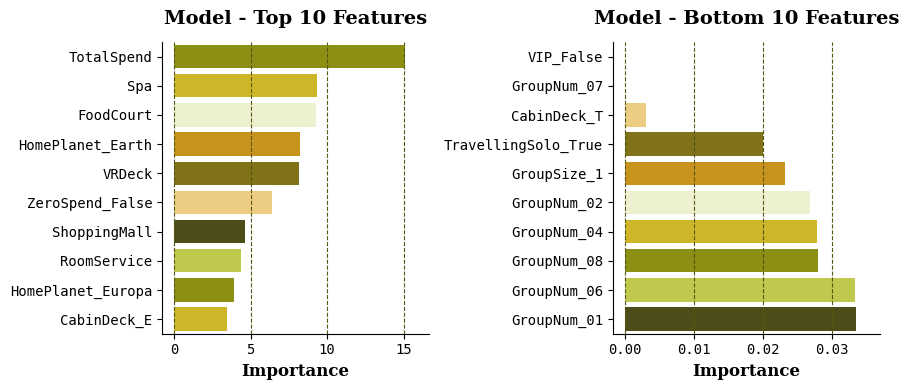

In [82]:
help.feature_importances(
	model=CBM_clf,
	feature_names=feature_names_2,
)

**CatBoost Feature Importance: Spending Rules All**

- **Top Features**:
  - **TotalSpend**, **Spa**, and **FoodCourt** dominate â€“ spending habits are key.
  - **HomePlanet_Earth** and **VRDeck** also matter, because location and activities are significant.

- **Bottom Features**:
  - **VIP_False**, **GroupNum_07**, and **CabinDeck_T** barely move the needle â€“ irrelevant noise.
  - Group numbers in general contribute very little.

*TL;DR*: Spending-related features drive predictions, while group numbers and VIP status are just filler.


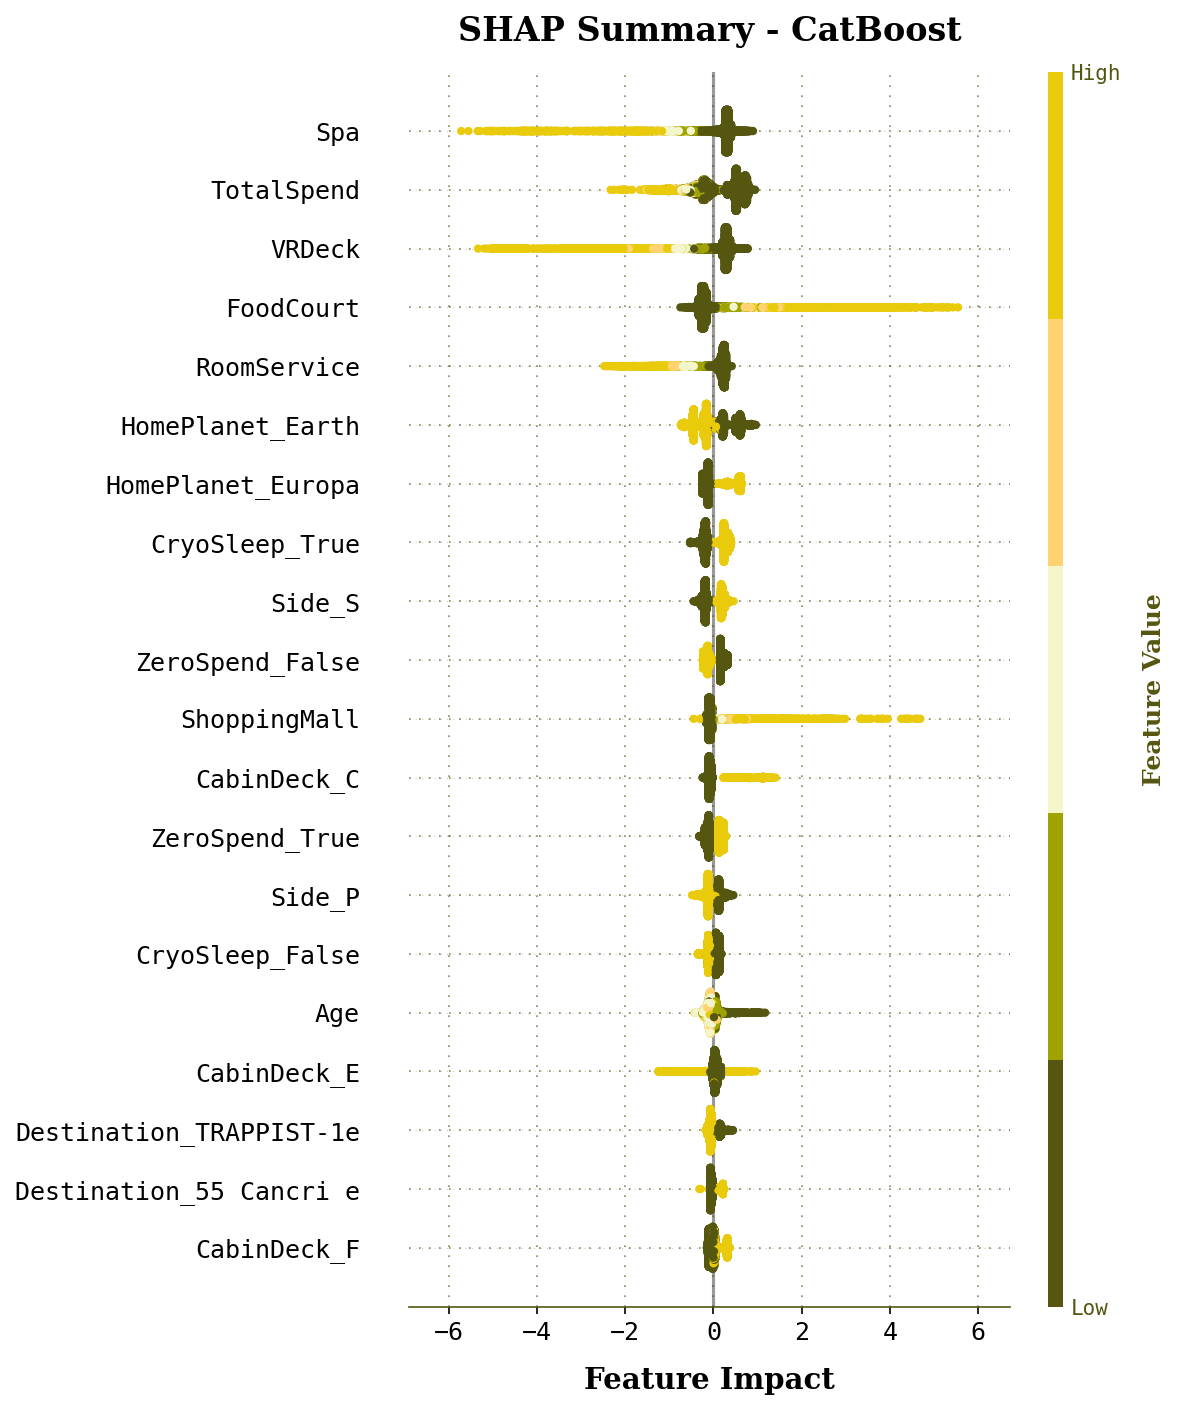

In [83]:
help.shap_summary(
	model=CBM_clf,
	X=X_Train_2,
	feature_names=feature_names_2,
	model_name="CatBoost"
)

**SHAP Summary: CatBoost's Priorities**

- **Top Features**:
  - **Spa**, **VRDeck**, and **FoodCourt** dominate â€“ spending habits are the MVPs.
  - **RoomService**, **ShoppingMall** and **TotalSpend** also play key roles.

- **Lower Impact**:
  - Features like **CryoSleep**, **CabinDeck_F**, and **Side_P** barely matter.

*TL;DR*: The model loves spending-related features, while others are just along for the ride.

## kaggle-submission-the-final-showdown
___

In [84]:
submission = pd.read_csv("../data/sample_submission.csv")

submission_1 = submission.copy()
submission_2 = submission.copy()
submission_3 = submission.copy()
submission_4 = submission.copy()

CBM_clf_basic.fit(X_Train, y)
test_predictions_1 = CBM_clf_basic.predict(X_Test)

CBM_clf_basic.fit(X_Train_2, y_2)
test_predictions_2 = CBM_clf_basic.predict(X_Test_2)

test_predictions_3 = CBM_clf.predict(X_Test_2)
test_predictions_4 = stacking_clf.predict(X_Test_2)

submission_1["Transported"] = test_predictions_1.astype(bool)
submission_2["Transported"] = test_predictions_2.astype(bool)
submission_3["Transported"] = test_predictions_3.astype(bool)
submission_4["Transported"] = test_predictions_4.astype(bool)

submission_1.to_csv("../submissions/submission1.csv", index=False)
submission_2.to_csv("../submissions/submission2.csv", index=False)
submission_3.to_csv("../submissions/submission3.csv", index=False)
submission_4.to_csv("../submissions/submission4.csv", index=False)

In [90]:
subprocess.run(["kaggle", "competitions", "submit", "-c", "spaceship-titanic",
                "-f", "../submissions/submission1.csv", "-m",
				"CatBoost classifier//high cardinality//no tuning"], check=True)

subprocess.run(["kaggle", "competitions", "submit", "-c", "spaceship-titanic",
                "-f", "../submissions/submission2.csv", "-m",
				"CatBoost classifier//low cardinality//no tuning"], check=True)

subprocess.run(["kaggle", "competitions", "submit", "-c", "spaceship-titanic",
                "-f", "../submissions/submission3.csv", "-m",
				"CatBoost classifier//low cardinality//with tuning"], check=True)

subprocess.run(["kaggle", "competitions", "submit", "-c", "spaceship-titanic",
                "-f", "../submissions/submission4.csv", "-m",
				"Stacking classifier//low cardinality//with tuning"], check=True)

CompletedProcess(args=['kaggle', 'competitions', 'submit', '-c', 'spaceship-titanic', '-f', '../submissions/submission4.csv', '-m', 'Stacking classifier//low cardinality//with tuning'], returncode=0)

**Kaggle Submission: The Final Showdown**

We tested **4 models** on Kaggle's Spaceship Titanic competition:

1. **Submission 1**: CatBoost (high cardinality, no tuning).
2. **Submission 2**: CatBoost (low cardinality, no tuning).
3. **Submission 3**: CatBoost (low cardinality, with tuning).
4. **Submission 4**: StackingClassifier (low cardinality, with tuning).

- **Predictions Saved**: Each model's results were saved as `submission1.csv`, `submission2.csv`, `submission3.csv`, and `submission4.csv`.
- **Kaggle Submission Command**: Models were submitted with appropriate descriptions using the `subprocess.run` method.

## results
___

**Submission Results Overview**

Hereâ€™s a snapshot of the submission results for the Spaceship Titanic competition:

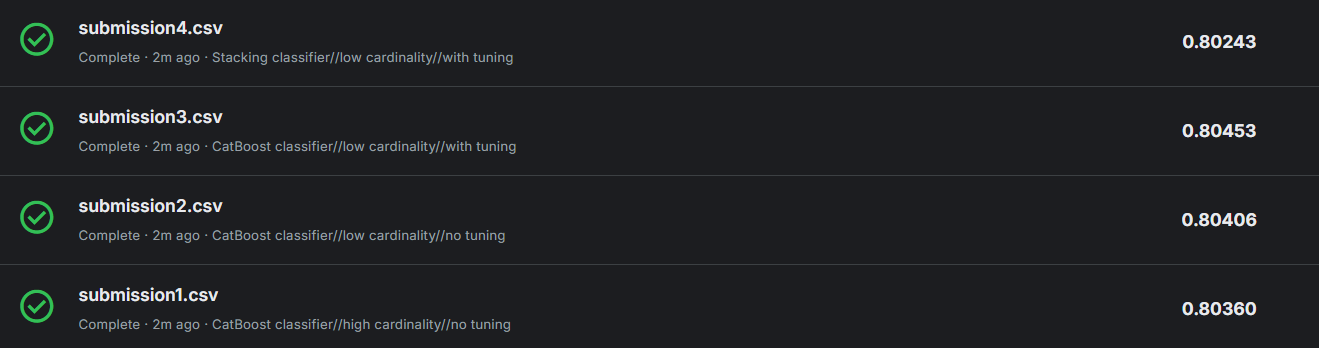

In [4]:
Image(filename="../images/Submissions.png")

**Stacking Triumph: Top Spot Secured**

After testing twice the amount on tree-based models and combining them into a stacked classifier, we achieved **spot 128** in the leaderboard. Hard work pays off! ðŸŽ‰

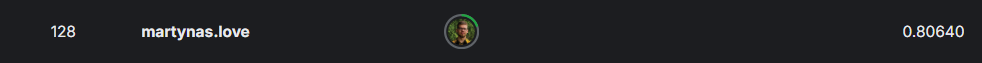

In [5]:
Image(filename="../images/Leaderboard.png")

# Summary of Spaceship Titanic Notebook

## Key Insights
1. **Data Exploration**:
   - Spending habits (`Spa`, `VRDeck`, `FoodCourt`) dominate predictions.
   - CryoSleep status and cabin deck significantly impact transport probability.
   - Younger passengers are more likely to be transported.

2. **Feature Engineering**:
   - Created `TotalSpend` (sum of luxury spending features) and `AgeGroup` (binned age ranges).
   - Dropped high-cardinality features (`CabinNumber`, `Group`, etc.) for better model performance.

3. **Model Evaluation**:
   - **Top Models**:
     - **CatBoostClassifier**: Accuracy = 80.90%, F1-Score = 0.84.
     - **StackingClassifier**: Accuracy = 80.81%, F1-Score = 0.85.
   - Spending-related features consistently rank as the most important predictors.

4. **Kaggle Submissions**:
   - Four models submitted, with the StackingClassifier achieving the best leaderboard position (#128).

---

## Recommendations
1. **Focus on Spending Features**:
   - Refine spending-related features further to capture non-linear relationships.

2. **Optimize StackingClassifier**:
   - Improve hyperparameter tuning for base and meta-models to enhance performance.

3. **Automate Feature Engineering**:
   - Streamline repetitive tasks like binning ages and imputing missing values for faster iteration.

4. **Drop High-Cardinality Features**:
   - Continue excluding features like `CabinNumber` and `Group` that add noise without improving predictions.

5. **Explore Ensemble Methods**:
   - Combine additional models or use advanced ensemble techniques for robustness.

6. **Validate on Unseen Data**:
   - Ensure robust validation by testing models on unseen data to avoid overfitting.

---

## Conclusion
The notebook demonstrates a thorough approach to data preprocessing, modeling, and Kaggle submissions. The use of advanced imputation techniques and ensemble methods resulted in competitive performance on the leaderboard. Further optimization could push results even higher!
